#  Finding cheaters from the results of the 2017 Marine Corps Marathon (Washington, DC)



The Marine Corps Marathon (MCM), known for its size, lottery entry, and Marines who hand out medals to runners at the finish line, is held annually in late October around the DC area.

I've written a __[blog post](https://dunkemo.wordpress.com/2017/10/30/reviewing-2017-mcm-results/)__ about the 2017 race to show the kind of analysis I do with race results, as well as to identify cheaters that the race has trouble finding on its own.

I scraped the results into an XLSX file. The authentic race data can be found online at the following URLs --

http://results.xacte.com/?id=1896 (directly to 2017 MCM)

http://www.marinemarathon.com/results/marathon (MCM site)

Note: the data were scraped within a few days of the race (Sunday, October 22, 2017). Since that time, the race has added and removed results. We'll see who were added and removed as of December 28, 2017, toward the end of this file.

In [1]:
# import modules

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re
import unicodedata
import itertools
from helperFunctions import BQlookup2, get_sec, get_time, getDivision, addColumns2, raceFullStats_DF

In [2]:
# In this block, I'm setting up variables to hold the timing mat locations.
# "tenK" and "halfway" are the names of the columns that contain split times at 10K & halfway
# "tenK" will be used shortly when splitting runners into "easy" & "hard" categories
# "halfway" will be used quite often
marDist = 26.21875 # marathon distance in miles
fiveK = 3.106856 # 5 kilometers in miles
halfDist = 0.5*marDist # half marathon distance in miles

 # every 5K, plus half
mats = [fiveK, fiveK*2, fiveK*3, fiveK*4, halfDist, fiveK*5, fiveK*6, fiveK*7, fiveK*8, marDist]

timingmats = {}
for i in range(len(mats)):
    timingmats.update({i+1:mats[i]})

findhalf = [abs(x - 0.5*marDist) for x in mats]
halfway_index = (findhalf.index(min(findhalf))) # 1 if 'split2_time', 2 if 'split3_time', etc
halfway = "split" + str(halfway_index+1) + "_time"
findtenK = [abs(x - fiveK*2) for x in mats]
tenK_index = (findtenK.index(min(findtenK)))
tenK = "split" + str(tenK_index+1) + "_time"
print(tenK)
print(halfway)

split2_time
split5_time


In this file, you'll be seeing a lot of the *split5_time* column.

This is because we're very interested in how people slow down or speed up after halfway (i.e., whether they positive-split or negative-split).

Oftentimes, we'll be looking at *split5_time* with *2ndhalf* side-by-side, along with *splits* (*2ndhalf - split5_time*, in seconds) or *splits_t* (*2ndhalf - split5_time*, in (+/-)MM:SS format)

In [3]:
# data import (and cleaning!!)

filename = "2017mcmdetails_20171027.xlsx"
dfr = pd.read_excel(filename)
ageUp = True
dfr.rename(columns = {'finish_guntime': 'gun',
                      'finish_time': 'chip',
                      'finish_chiptime': 'chip',
                      'chip_time': 'chip',
                      'place_y': 'place'}, inplace=True)
dfr = dfr[dfr.chip.notnull()]
dfr = dfr[~dfr.chip.str.isspace()]
dfr = dfr[~dfr.chip.isin(["DNF","-DNF-","DNS","DQ","DSQ","00:00:00","0:00:00"])]

dfr.reset_index(drop=True,inplace=True)
dfr['name'].replace(np.nan,u'UNKNOWN',inplace=True)
dfr['name'] = dfr.apply(lambda row: unicodedata.normalize('NFD', row['name']).encode('ascii', 'ignore'),axis=1)
dfr['name'] = dfr.name.str.replace("\.","").str.strip()
dfr.columns = [x.replace("_chiptime","_time") for x in dfr.columns]

for x in [('split'+str(y)+'_time') for y in range(1,len(mats))]:
    dfr[x].replace("00:00:00","",inplace=True)
    dfr[x].replace("-","",inplace=True)
    dfr[x].replace(regex=r'\s+',value="",inplace=True)
    dfr[x].replace(np.nan,"",inplace=True)
    dfr[x] = dfr.apply(lambda row: row[x] if "Predicted" not in row[x] else "", axis=1)

print(len(dfr))

20119


In [4]:
print(len(dfr.columns))
dfr.columns

47


Index([           u'bib',           u'name',        u'sex_age',
                 u'city',    u'split1_time',    u'split2_time',
          u'split3_time',    u'split4_time',    u'split5_time',
          u'split6_time',    u'split7_time',    u'split8_time',
          u'split9_time',           u'chip',      u'start_lag',
       u'split1_guntime', u'split2_guntime', u'split3_guntime',
       u'split4_guntime', u'split5_guntime', u'split6_guntime',
       u'split7_guntime', u'split8_guntime', u'split9_guntime',
                  u'gun',    u'split1_pace',    u'split2_pace',
          u'split3_pace',    u'split4_pace',    u'split5_pace',
          u'split6_pace',    u'split7_pace',    u'split8_pace',
          u'split9_pace',    u'finish_pace',      u'int1_pace',
            u'int2_pace',      u'int3_pace',      u'int4_pace',
            u'int5_pace',      u'int6_pace',      u'int7_pace',
            u'int8_pace',      u'int9_pace',     u'int10_pace',
                  u'sex',            u'a

In [5]:
dfr.head()

,bib,name,sex_age,city,split1_time,split2_time,split3_time,split4_time,split5_time,split6_time,...,int3_pace,int4_pace,int5_pace,int6_pace,int7_pace,int8_pace,int9_pace,int10_pace,sex,age
0,16,DESTA BERISO MORKAMA,Male / 32,"ARLINGTON, VA",17:58,,,1:07:42,1:11:26,1:24:38,...,NaN,NaN,5:27,5:26,5:30,NaN,NaN,5:53,M,32
1,149,WESLEY TURNER,Male / 31,"DANVILLE, VA",17:51,34:37,51:50,1:08:51,1:12:39,1:26:10,...,5:32,5:28,5:34,5:34,5:34,5:38,5:54,6:00,M,31
2,13,KIERAN O'CONNOR,Male / 30,"ARLINGTON, VA",16:55,33:19,49:38,1:06:04,1:09:42,1:22:50,...,5:15,5:17,5:19,5:24,5:36,5:47,6:22,7:21,M,30
3,71,KRISTOPHER HOUGHTON,Male / 36,"ALBUQUERQUE, NM",17:58,34:29,51:01,1:07:42,1:11:25,1:24:42,...,5:19,5:22,5:28,5:28,5:40,5:55,6:06,6:23,M,36
4,63,PATRICK HEARN,Male / 27,"IRVINE, CA",18:16,35:14,52:28,1:09:36,1:13:28,1:27:05,...,5:32,5:30,5:39,5:37,5:40,5:44,5:53,5:59,M,27


In [6]:
dfr = addColumns2(dfr, 'chip','sex','age', ageUp, mats) # age_up is 5th input
# Because 2017 MCM is a qualfier for 2019 Boston, all runners "age up" a year.
# For example, this means that a 34-year-old has a BQ requirement of a 35-year-old.
# addColumns2 calculates split paces, BQ reqs, splits, stdpace, and many other metrics.
# a pink RuntimeWarning box might appear directly below --
#  (when calculating stdpace, some runners have no split times, and therefore stdpace=NaN)

20119 records
81.9149289433 (median stdpace)
24:11 (median splits)


/Users/donwang/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


In [7]:
print(len(dfr.columns))
dfr.columns

96


Index([                        u'bib',                        u'name',
                           u'sex_age',                        u'city',
                       u'split1_time',                 u'split2_time',
                       u'split3_time',                 u'split4_time',
                       u'split5_time',                 u'split6_time',
                       u'split7_time',                 u'split8_time',
                       u'split9_time',                        u'chip',
                         u'start_lag',              u'split1_guntime',
                    u'split2_guntime',              u'split3_guntime',
                    u'split4_guntime',              u'split5_guntime',
                    u'split6_guntime',              u'split7_guntime',
                    u'split8_guntime',              u'split9_guntime',
                               u'gun',                 u'split1_pace',
                       u'split2_pace',                 u'split3_pace',
      

In [8]:
dfr.describe()

/Users/donwang/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,bib,age,seconds,BQ,epoch,BQpace_sec,split1_score,split2_score,split3_score,split4_score,...,2ndhalfpace,1sthalfpace,pace_diff,splits,mm_len,stdpace,pacesdiff,biggestslowdown,slowest_split,fastest_split
count,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,20119.000000,19302.000000,19953.000000,19958.000000,19924.000000,...,18656.000000,18656.000000,18656.000000,18656.00000,20119.00000,20115.000000,20115.000000,20119.000000,20119.000000,20119.000000
mean,15485.364432,40.451961,18188.961877,0.034495,719163.210520,487.011222,150.958438,137.854393,139.928150,143.119598,...,749.204411,628.380527,120.823884,1583.92560,0.33108,91.250176,293.937466,7.385109,8.560366,2.951041
std,8468.680181,11.002700,3308.994351,0.182501,0.038299,46.371559,89.818065,90.900355,94.221925,98.651448,...,157.152205,109.787798,89.795607,1177.16429,0.71496,104.787626,379.763954,1.944863,2.120915,1.790704
min,13.000000,14.000000,8714.000000,0.000000,719163.100856,423.361144,-169.406664,-297.186150,-206.359413,-163.899554,...,337.773540,319.008343,-282.164482,-3699.00000,0.00000,2.455726,0.000000,0.000000,0.000000,0.000000
25%,8038.500000,32.000000,15748.500000,0.000000,719163.182274,446.245530,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,6.000000,9.000000,2.000000
50%,15606.000000,40.000000,18047.000000,0.000000,719163.208877,492.014303,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.00000,NaN,NaN,8.000000,9.000000,2.000000
75%,22896.500000,48.000000,20647.000000,0.000000,719163.238970,514.898689,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,9.000000,10.000000,4.000000
max,30000.000000,82.000000,26627.000000,1.000000,719163.308183,709.415971,876.925388,626.028662,607.370030,593.423595,...,1440.419547,1078.693683,931.089392,12206.00000,9.00000,5933.853144,20919.056134,10.000000,10.000000,10.000000


### Preliminary exploratory data analysis

In [9]:
pd.set_option('max_colwidth',120)

dfrFULL = raceFullStats_DF(dfr,'sex','age')
dfrFULL

,#_run,#_BQs,BQ%,BQ_time,Min_time,Med_time,Mean_time,Max_time
Age_Group,,,,,,,,
F0-34,3449,124,3.6%,3:35,2:50:24,4:59:15,5:02:51,7:16:00
F35-39,1508,51,3.4%,3:40,2:45:07,5:09:56,5:11:55,7:19:34
F40-44,1507,38,2.5%,3:45,3:07:03,5:17:49,5:18:33,7:16:31
F45-49,1235,39,3.2%,3:55,3:18:07,5:22:19,5:23:36,7:23:47
F50-54,907,34,3.7%,4:00,3:20:16,5:28:27,5:27:52,7:14:01
F55-59,441,24,5.4%,4:10,3:36:08,5:28:17,5:29:47,7:07:15
F60-64,178,9,5.1%,4:25,3:49:53,5:54:00,5:45:08,7:10:55
F65-69,66,4,6.1%,4:40,3:43:02,6:06:05,5:59:24,7:08:59
F70-74,16,1,6.2%,4:55,4:42:40,6:04:40,6:05:52,7:13:10


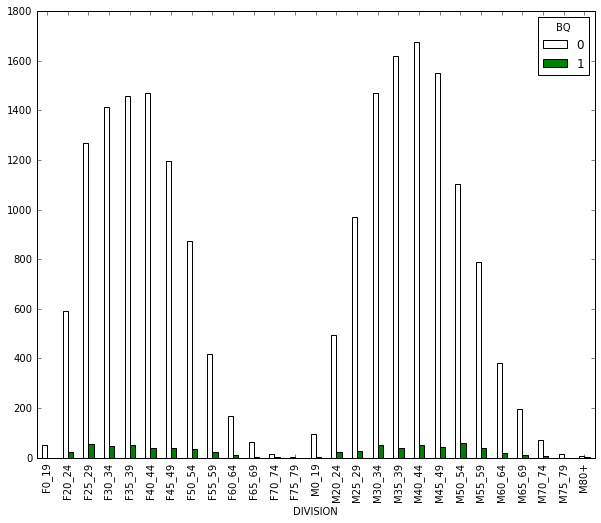

In [10]:
# plot histogram of AGs & BQs
AGbqs = pd.pivot_table(dfr, columns='BQ', values='bib', index ='DIVISION', aggfunc=len)
AGbqs.plot(kind='bar',stacked=False,color = ['white','green'], figsize=[10,8])
plt.show()

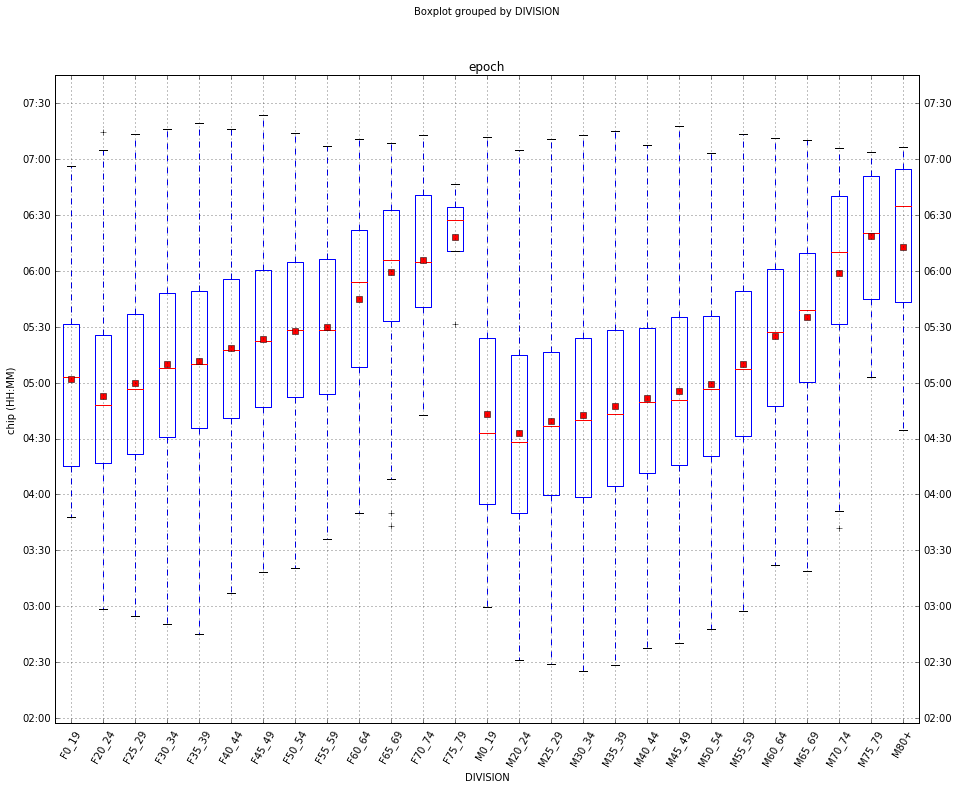

In [11]:
ax = dfr.boxplot(column='epoch',by='DIVISION',figsize=(15,12),rot=60, showmeans=True)
yformatter = mdates.DateFormatter('%H:%M')
ylocator = mdates.MinuteLocator(byminute=[0,30], interval = 1)

## Set ytick labels to appear every 30 minutes
ax.yaxis.set_major_locator(ylocator)
ax.tick_params(labeltop=False, labelright=True)

## Format ytick labels as HH:MM
plt.gcf().axes[0].yaxis.set_major_formatter(yformatter)
plt.ylabel('chip (HH:MM)')
plt.ylim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*7.75)])
plt.show()

Note that there are a couple fast outliers in the F65-69 group (and a couple in other groups).

One of them is easily explained by cheating, as we'll see toward the end.

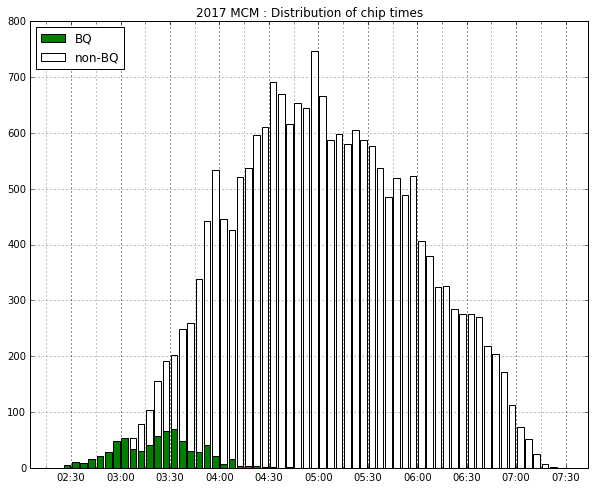

In [12]:
# plot histogram of finish times, with bin sizes of 5 minutes !!

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1)]['epoch'],dfr[(dfr.BQ==0)]['epoch']], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    stacked=True, color = ['green','white'], histtype='bar',align='mid',label=['BQ','non-BQ'])
ymax = max(ax.get_ylim())
xmax = dfr.seconds.max() + 60*20
xmin = dfr.seconds.min() - 60*20

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.title("2017 MCM : Distribution of chip times")
plt.xlim([mdates.epoch2num(xmin),mdates.epoch2num(xmax)])
plt.show()

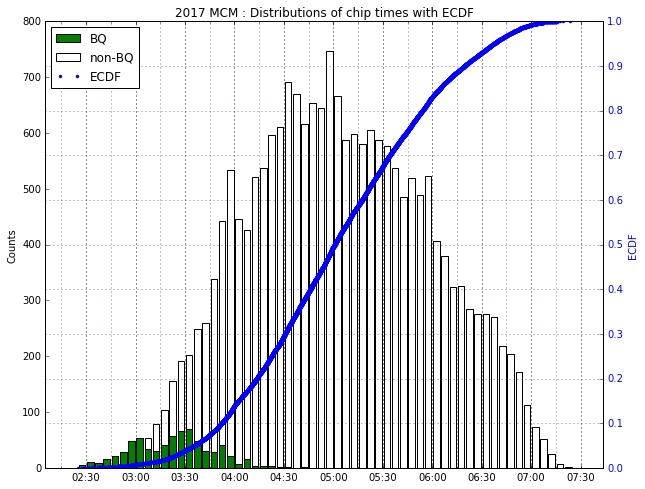

In [13]:
# we can add an ECDF (empirical cumulative distribution function) to the above plot

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1)]['epoch'],dfr[(dfr.BQ==0)]['epoch']], 
    bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), 
    stacked=True, color = ['green','white'], histtype='bar',align='mid',label=['BQ','non-BQ'])

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
ax.set_ylabel('Counts', color='k')
ax.grid(which='both',axis='x')

# add ECDF
ax2 = ax.twinx()
x = dfr.epoch.sort_values()
y = np.arange(1, len(x)+1)*1.0/len(x)
ax2.plot(x,y, marker='.', linestyle='none',label='ECDF')
ax2.set_ylabel('ECDF', color='b')
ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1)) # set tick labels at 0.1 steps (default was 0.2)
ax2.tick_params('y', colors='b')
ax2.grid(which='both',axis='y', color='b')

# make sure that legend has entries from both ax & ax2
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.title("2017 MCM : Distributions of chip times with ECDF")
plt.xlim([mdates.epoch2num(xmin),mdates.epoch2num(xmax)])
plt.show()

With the above, we can visually verify that the median time is in the 5:00-5:05 bin (by where the string of blue dots crosses the 0.5 dotted line on the secondary y-axis).

A runner would have had to finish in the 3:50-3:55 range to be in the top 10%.

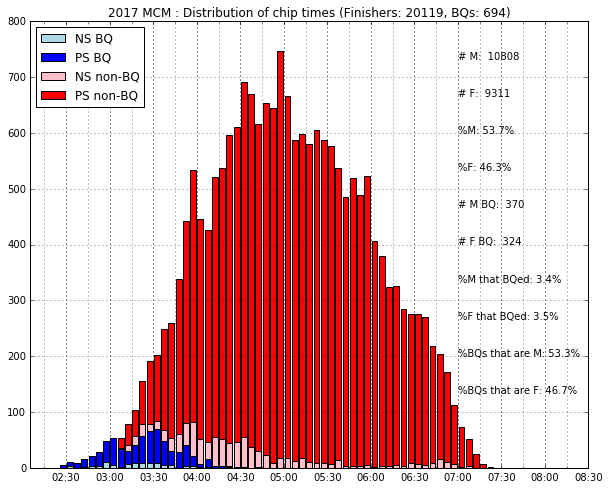

In [14]:
# re-draw the above histogram, but add more details

fig, ax = plt.subplots(1,1, figsize=(10,8))
ax.hist([dfr[(dfr.BQ==1) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==1) & ((dfr.splits>=0) | dfr.splits.isnull())]['epoch'],dfr[(dfr.BQ==0) & (dfr.splits<0)]['epoch'],dfr[(dfr.BQ==0) & ((dfr.splits>=0) | dfr.splits.isnull())]['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*8,60*5)), stacked=True, color = ['lightblue','blue','pink','red'], histtype='bar',align='mid',label=['NS BQ','PS BQ','NS non-BQ', 'PS non-BQ'])
ymax = max(ax.get_ylim())
xmax = 60*60*8.5
lines_of_text = 12

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')
plt.legend(loc='upper left')
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-1),"# M:  " + str(len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# F:  " + str(len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-3),"%M: {:.1%}".format(len(dfr[(dfr.sex=='M')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%F: {:.1%}".format(len(dfr[(dfr.sex=='F')])*1.0/len(dfr)))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-5),"# M BQ:  " + str(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# F BQ:  " + str(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-7),"%M that BQed: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='M'])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-8),"%F that BQed: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.sex=='F'])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-9),"%BQs that are M: {:.1%}".format(len(dfr[(dfr.sex=='M') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.text(mdates.epoch2num(xmax-60*90),1+(ymax-2)/lines_of_text*(lines_of_text-10),"%BQs that are F: {:.1%}".format(len(dfr[(dfr.sex=='F') & (dfr.BQ==1)])*1.0/len(dfr[dfr.BQ==1])))
plt.title("2017 MCM : Distribution of chip times (Finishers: " + str(len(dfr)) + ", BQs: " + str(len(dfr.query("BQ==1"))) + ")")
plt.xlim([mdates.epoch2num(xmin),mdates.epoch2num(xmax)])
plt.show()

With the above, we can see that a small portion of all runners ran negative splits, whether or not they BQed.

The numbers in the race stats table higher up are shown on the plot: men outnumbered women at the race (which is generally true at marathons), but women were better at running BQs that day. Women accounted for 46.7% of the BQs even though the race was only 46.3% female.

Next, we split all finishers into "easy" and "hard" groups. (I've written a __[blog post](https://dunkemo.wordpress.com/2017/08/03/easy-vs-hard/)__ about this.)

This is to get a better idea of who are actually trying to run fast and qualify for Boston, out of the 20000+ finishers.

### Brief description of metrics, easy/hard

addColumns2 calculated lots of metrics and added lots of columns to the dataframe.

Let's take a look at the frequently reported columns that you'll see in in the rest of the file.

In [15]:
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits','mm','non_missing_splitpaces_time','stdpace']
dfr.sample(5)[columns_i_want]

,BQ,bib,name,age,chip,split5_time,2ndhalf,splits,mm,non_missing_splitpaces_time,stdpace
19561,0,21174,AMANDA PIRO,31,6:47:22,3:06:23,3:40:59,2076.0,"[1, 8]","[13:53, 13:59, 15:08, 14:03, 15:04, 16:21, 17:14, 19:28]",116.918094
3802,0,23568,VALERIE MCGUIRE,40,4:11:24,1:55:25,2:15:59,1234.0,[],"[8:22, 8:43, 9:15, 8:49, 9:05, 9:04, 9:35, 9:54, 11:36, 12:47]",83.937623
5396,0,23516,MICHAEL MCNETT,52,4:25:47,2:07:25,2:18:22,657.0,[],"[9:38, 9:36, 9:39, 10:00, 9:44, 9:40, 9:45, 10:27, 11:12, 12:43]",60.305148
5616,0,29940,JEFF HAVENER,42,4:27:35,1:59:35,2:28:00,1705.0,[],"[9:19, 8:51, 9:08, 9:10, 9:11, 10:18, 11:17, 11:50, 11:33, 11:12]",70.760898
1052,0,24537,SASHA BAZHINA,30,3:36:28,1:42:56,1:53:32,636.0,[],"[8:22, 7:39, 7:45, 7:40, 7:45, 7:43, 8:15, 9:12, 9:14, 8:46]",38.121874


Many of the data fields are self explanatory: BQ, bib, name, age

__*splits*__: difference, in seconds, between a runner's first & second halves of the race (second half minus first half). Positive values indicate a slower second half.

__*mm*__: stands for "missing mats". An empty list indicates no missing splits. A value of, say, [2], means that the 2nd timing mat didn't detect the runner passing through at that location.

__*non_missing_splitpaces_time*__: self-explanatory (the _time_ suffix refers to MM:SS time format and is meant to differentiate this from *non_missing_splitpaces* (another column in the dataframe, which has split paces in seconds per mile (floating point, not integers))).

__*stdpace*__: standard deviation, in seconds, of a runner's split paces. *stdpace* is calculated based on the numbers in *non_missing_splitpaces*. Oftentimes we will sort results by *stdpace* (in descending order) to see cases of extreme pacing fluctuations listed first.

Let's take a look at some more metrics --

In [16]:
columns_i_want = ['BQ','bib', 'name', 'sex','age','BQreq','BQpace','pace','split1_pace','split2_pace','split1_score','split2_score']
dfr.sample(5)[columns_i_want]

,BQ,bib,name,sex,age,BQreq,BQpace,pace,split1_pace,split2_pace,split1_score,split2_score
14047,0,27501,DEBRA MAYEUX,F,48,3:55:00,8:58,12:44,11:13,11:08,134.922709,130.416545
15255,0,11139,ASHLEY COUNT,F,34,3:40:00,8:23,13:11,12:32,12:20,248.429012,236.519866
12346,0,21027,ELLIOT MANEGOLD,M,40,3:15:00,7:26,12:11,10:47,10:25,201.032618,178.984606
16341,0,20258,KENNETH SCHLAX,M,29,3:05:00,7:03,13:36,11:52,11:30,288.934501,266.403686
11992,0,22579,DAVID TICHENOR,M,32,3:05:00,7:03,12:04,11:09,11:05,245.482214,241.941657


__BQreq__: a runner's BQ requirement, based on age & sex

__BQpace__: calculated from *BQreq*

__pace__: a runner's overall pace at the finish, calculated from *chip*

__split1_pace/split2_pace/splitX_pace__: a runner's cumulative pace at the timing mat location, calculated from *splitX_time*, rounded from units of seconds/mile to MM:SS format

__split1_score/split2_score/splitX_score__: the difference between *splitX_pace* and *BQpace*, in seconds/mile (unrounded). Negative values indicate that a runner is ahead of BQ pace at that timing mat. (Think of "score" in terms of golf scores: the lower the better, in terms of being ahead of pace for a BQ.)

Below, we see how a runner's "scores" at 10K & halfway determine how they're classified: "easy" (not running fast for a BQ) or "hard" (chasing a BQ) --

In [17]:
# split runners into 2 categories:
# easy -- those not going for BQs 
# (those who didn't BQ, and weren't within 0:20/mi of their BQ pace at both 10K and halfway)
# hard -- those going for BQs

margin = 20 # seconds

easy = dfr[(dfr['BQ'].isin([0]) & 
    ( ((dfr[tenK.replace("time","score")]) > margin) |
    ((dfr[halfway.replace("time","score")]) > margin)  )) |
    (dfr['BQ'].isin([0]) & dfr[tenK.replace("time","score")].isnull() & dfr[halfway.replace("time","score")].isnull()) ]
hard = dfr.ix[(list(set(dfr.index) - set(easy.index)))]
print(len(easy))
print(len(hard))

18266
1853


The margin of 20 seconds was picked arbitrarily, but it seems reasonable. A runner behind BQpace by 0:20/mi at halfway is behind by around 4 minutes and 20 seconds, which means that she would have to run the second half in 8:40 in order to break even and BQ.

My reasoning is that a runner can't be considered to be going "hard" if she's behind by that much at both 10K and halfway.

Next, let's print some stats concerning easy/hard runners --

In [18]:
# some stats comparing easy & hard BQers & hard non-BQers
print("'splits' metric --")
print("{} (everyone)".format(get_time(dfr['splits'].median())))
print("{} (easy)".format(get_time(easy['splits'].median())))
print("{} (hard)".format(get_time(hard['splits'].median())))
print("{} (hard BQs)".format(get_time(hard.query("BQ==1")['splits'].median())))
print("{} (hard non-BQs)".format(get_time(hard.query("BQ==0")['splits'].median())))
print("")
print("'stdpace' metric --")
print("{} (everyone)".format(dfr['stdpace'].median()))
print("{} (easy)".format(easy['stdpace'].median()))
print("{} (hard)".format(hard['stdpace'].median()))
print("{} (hard BQs)".format(hard.query("BQ==1")['stdpace'].median()))
print("{} (hard non-BQs)".format(hard.query("BQ==0")['stdpace'].median()))

'splits' metric --
24:11 (everyone)
25:41 (easy)
12:50 (hard)
5:03 (hard BQs)
19:00 (hard non-BQs)

'stdpace' metric --
81.9149289433 (everyone)
85.4829044395 (easy)
46.3531869164 (hard)
24.7017072321 (hard BQs)
62.2603021034 (hard non-BQs)


One of the things that J Ward, the professional runner and statistics professor, said about his findings from 2013 SG was that BQ runners varied their paces __*more*__ than non-BQ runners.

The *stdpace* numbers above, however, don't support his argument. (Recall that *stdpace* is the standard deviation of a runner's split paces, and low standard deviation means less variation.)

Let's plot *stdpace* values for "hard" runners only. We've limited the y-axis to 100 --

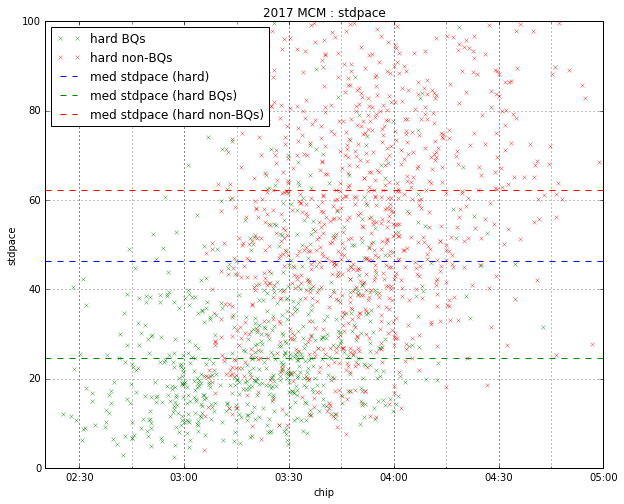

In [19]:
# plotting stdpace by chip time (non-BQ runners have higher stdpace values)
fig, ax = plt.subplots(1,1, figsize=(10,8))

plotx = hard.query("BQ==1")['epoch']
ploty = hard.query("BQ==1")['stdpace']
ax.plot(plotx, ploty, 'gx', aa=True, markersize=4, alpha=0.7, label='hard BQs')

plotx = hard.query("BQ==0")['epoch']
ploty = hard.query("BQ==0")['stdpace']
ax.plot(plotx, ploty, 'rx', aa=True, markersize=4, alpha=0.7, label='hard non-BQs')

ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.xticks(rotation=0)
plt.grid(which='both',axis='both')

plt.title("2017 MCM : stdpace")
plt.xlim([mdates.epoch2num(hard.query("BQ==1")['seconds'].min()-60*5),mdates.epoch2num(60*60*5)])
plt.ylim(0,100)
plt.axhline(hard['stdpace'].median(),linestyle='--', color='b', label='med stdpace (hard)')
plt.axhline(hard.query("BQ==1")['stdpace'].median(),linestyle='--', color='g', label='med stdpace (hard BQs)')
plt.axhline(hard.query("BQ==0")['stdpace'].median(),linestyle='--', color='r', label='med stdpace (hard non-BQs)')
plt.legend(loc='upper left')
plt.xlabel('chip')
plt.ylabel('stdpace')
plt.show()

Certainly there are instances where BQ runners have high stdpace values, and non-BQ runners have low stdpace values, but it's clear that most BQ runners had lower stdpace values. Median values don't lie!

We can print additional stats regarding the following: 

-  negative splits
-  all descending/ascending split paces
-  all descending/ascending cumulative paces

In [20]:
print("Negative splits (M): {}".format(len(dfr[(dfr.splits<0) & (dfr.sex=='M')])))
print("Negative splits (F): {}".format(len(dfr[(dfr.splits<0) & (dfr.sex=='F')])))
print("NS BQs (M): {}".format(len(dfr[(dfr.BQ==1) & (dfr.splits<0) & (dfr.sex=='M')])))
print("NS BQs (F): {}".format(len(dfr[(dfr.BQ==1) & (dfr.splits<0) & (dfr.sex=='F')])))
print("")
print("{} all descending split paces".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("{} all ascending split paces".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("")
print("{} all descending cumulative paces".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))
print("{} all ascending cumulative paces".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1))).sum()))
print("{} BQs".format(((dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted)) & (dfr.mm_len < (len(mats)-1)) & (dfr.BQ==1)).sum()))

Negative splits (M): 477
Negative splits (F): 491
NS BQs (M): 40
NS BQs (F): 48

4 all descending split paces
1 BQs
179 all ascending split paces
2 BQs

174 all descending cumulative paces
31 BQs
1795 all ascending cumulative paces
13 BQs


In [21]:
# number of people with all descending split paces
columns_i_want = ['BQ','name','sex','age','chip','mm','non_missing_splitpaces_time','non_missing_cumpaces']
(dfr.query("biggestslowdown==1")[columns_i_want])
(dfr[(dfr.non_missing_splitpaces == dfr.non_missing_splitpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))][columns_i_want])
# people with all descending cum paces (some might have all descending split paces too)
#(dfr[(dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.mm_len < (len(mats)-1))][columns_i_want])
# people with all descending cum paces (but not all descending split paces)
#(dfr[(dfr.non_missing_cumpaces == dfr.non_missing_cumpaces.apply(sorted,reverse=True)) & (dfr.biggestslowdown!=1) & (dfr.mm_len < (len(mats)-1))][columns_i_want])

,BQ,name,sex,age,chip,mm,non_missing_splitpaces_time,non_missing_cumpaces
273,0,AARON SMITH,M,20,3:12:02,"[1, 4]","[8:16, 7:25, 7:22, 7:15, 7:14, 6:37, 6:32, 6:22]","[496, 479, 469, 464, 459, 450, 443, 439]"
731,1,HARRY LINDE,M,58,3:29:07,"[1, 4, 5, 6, 7, 8, 9]","[8:55, 8:50, 7:28]","[535, 533, 479]"
12288,0,BALA KRISHNA LALAJI,M,39,5:19:08,"[1, 2, 3, 5, 6, 7, 8, 9]","[12:28, 11:55]","[748, 730]"
12925,0,MEREDITH COMNES,F,25,5:24:16,"[1, 3, 4, 6, 7, 8, 9]","[12:38, 12:28, 12:12]","[758, 752, 742]"


### Negative-split BQs

In [22]:
# negative split BQs -- trying to see if it's only super-fast people who can run NS BQs
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','splits_t','mm','non_missing_splitpaces_time']
nsbq = dfr[(dfr.BQ==1) & (dfr.splits < 0)]
print(len(nsbq))
print(nsbq['sex'].value_counts())
(dfr.assign(splits_t=map(get_time,dfr.splits))[(dfr.BQ==1) & (dfr.splits < 0)][columns_i_want].sample(10))

88
F    48
M    40
Name: sex, dtype: int64


,BQ,bib,name,age,chip,split5_time,2ndhalf,splits_t,mm,non_missing_splitpaces_time
545,1,21522,CANDICE WEISS,23,3:23:59,1:42:40,1:41:19,-1:21,[],"[8:01, 7:44, 7:56, 7:41, 7:40, 7:41, 7:40, 7:38, 7:51, 7:54]"
114,1,3575,MATTHEW DABROWSKI,30,2:57:37,1:29:44,1:27:53,-1:51,[],"[6:55, 6:54, 6:48, 6:45, 6:54, 6:42, 6:31, 6:40, 6:45, 7:05]"
246,1,21895,BAOQING LI,51,3:10:09,1:37:23,1:32:46,-4:37,[],"[7:58, 7:23, 7:19, 7:07, 7:08, 7:00, 7:01, 6:54, 7:11, 7:30]"
103,1,5481,JEREMIAH TATUM,44,2:57:02,1:28:36,1:28:26,-0:10,[],"[6:47, 6:44, 6:48, 6:43, 6:48, 6:45, 6:47, 6:42, 6:47, 6:41]"
489,1,4534,SANDRA PAHL,39,3:22:06,1:41:29,1:40:37,-0:52,[],"[8:41, 7:31, 7:25, 7:24, 7:32, 7:20, 7:26, 7:39, 8:02, 8:05]"
313,1,25218,ANGELA BUCH,21,3:14:32,1:38:21,1:36:11,-2:10,[],"[7:41, 7:24, 7:30, 7:27, 7:26, 7:28, 7:24, 7:20, 7:15, 7:13]"
348,1,22541,DANIEL NEFF,48,3:16:17,1:40:20,1:35:57,-4:23,[1],"[7:51, 7:29, 7:27, 7:33, 7:22, 7:24, 7:11, 7:16, 7:28]"
53,1,27851,PATRICK COOPER,29,2:48:19,1:26:08,1:22:11,-3:57,[],"[6:47, 6:28, 6:33, 6:31, 6:29, 6:24, 6:11, 6:09, 6:19, 6:23]"
604,1,21664,KATELYN STOREY,22,3:25:35,1:44:12,1:41:23,-2:49,[],"[8:17, 7:53, 7:57, 7:43, 7:46, 7:50, 7:54, 7:38, 7:41, 7:31]"
118,1,5433,JASON BLACK,23,2:58:26,1:29:27,1:28:59,-0:28,[],"[7:33, 6:36, 6:45, 6:27, 6:37, 6:33, 6:33, 6:49, 7:06, 6:58]"


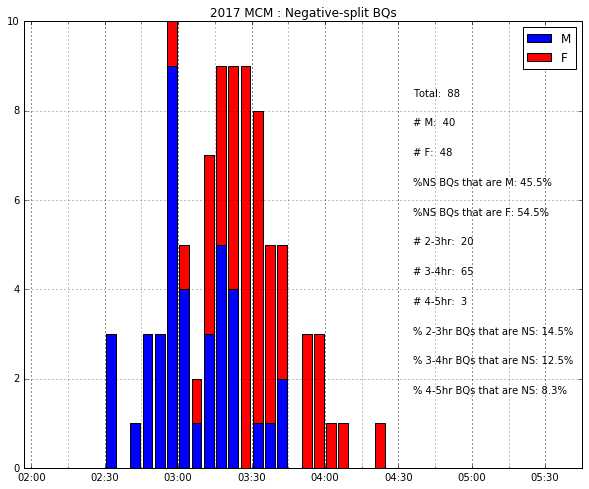

In [23]:
# plotting NS BQs
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.hist([nsbq.query("sex=='M'")['epoch'],nsbq.query("sex=='F'")['epoch']], 
         bins=mdates.epoch2num(np.arange(60*60*1.5,60*60*5.5,60*5)), stacked=True, color = ['blue','red'], histtype='bar',align='mid',label=['M','F'])
ymax = max(ax.get_ylim())
lines_of_text = 12
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-1),"Total:  " + str(len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-2),"# M:  " + str(len(nsbq[nsbq.sex=='M'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-3),"# F:  " + str(len(nsbq[nsbq.sex=='F'])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-4),"%NS BQs that are M: {:.1%}".format(len(nsbq[nsbq.sex=='M'])*1.0/len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-5),"%NS BQs that are F: {:.1%}".format(len(nsbq[nsbq.sex=='F'])*1.0/len(nsbq)))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-6),"# 2-3hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*2,60*60*3))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-7),"# 3-4hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*3,60*60*4))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-8),"# 4-5hr:  " + str(len(nsbq[nsbq.seconds.isin(range(60*60*4,60*60*5))])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-9),"% 2-3hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*2,60*60*3))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*2,60*60*3)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-10),"% 3-4hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*3,60*60*4))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*3,60*60*4)) & (dfr.BQ==1)])))
plt.text(mdates.epoch2num(60*60*4.6),1+(ymax-2)/lines_of_text*(lines_of_text-11),"% 4-5hr BQs that are NS: {:.1%}".format(len(nsbq[nsbq.seconds.isin(range(60*60*4,60*60*5))])*1.0/len(dfr[dfr.seconds.isin(range(60*60*4,60*60*5)) & (dfr.BQ==1)])))
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
xlocator = mdates.MinuteLocator(byminute=[0,15,30,45], interval = 1)
ax.xaxis.set_minor_locator(xlocator)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0,30], interval = 1))
plt.grid(which='both',axis='both')
plt.legend()
plt.title("2017 MCM : Negative-split BQs")
plt.xlim([mdates.epoch2num(60*60*1.95),mdates.epoch2num(60*60*5.75)])
plt.show()

### Comebacks, fades, and the NS/BQ contingency table

In [24]:
# comebacks (those who were behind BQ pace at halfway but BQed)
# (sorted by halfway score, or how far behind they are at halfway)
columns_i_want = ['BQ','bib','name','age',halfway.replace("time","score"),'BQreq','chip',halfway,'2ndhalf','splits_t','behindby','BQdiff_t','mm','stdpace','non_missing_splitpaces_time']
dfr.assign(behindby=map(get_time,dfr[halfway.replace("time","score")]*mats[halfway_index]),
    splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
    [dfr.BQ.isin([1]) & dfr.bib.isin(hard.bib)].sort_values(by=halfway.replace("time","score"),ascending=False)[columns_i_want][0:10]
# For example, the first runner shown was behind her BQ pace by 1:48 at halfway
# But then she ran the second half faster than her first half by -3:56, to BQ by 0:20

,BQ,bib,name,age,split5_score,BQreq,chip,split5_time,2ndhalf,splits_t,behindby,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
1203,1,28605,JAIME GLAUSER,35,8.238379,3:40:00,3:39:40,1:51:48,1:47:52,-3:56,1:48,-0:20,[],15.344338,"[9:02, 8:16, 8:24, 8:25, 8:30, 8:19, 8:15, 8:10, 8:13, 8:11]"
897,1,22456,BAYLEE CRONE,31,5.492253,3:35:00,3:33:04,1:48:42,1:44:22,-4:20,1:12,-1:56,[],21.456429,"[8:58, 8:00, 8:07, 8:08, 8:07, 8:07, 8:13, 7:54, 7:48, 7:35]"
2661,1,17888,BROOKE CURRAN,49,5.339690,4:00:00,3:58:50,2:01:10,1:57:40,-3:30,1:10,-1:10,[],15.496772,"[9:45, 9:07, 9:09, 9:00, 9:01, 9:01, 9:07, 8:53, 8:59, 8:46]"
4936,1,11015,COLLEEN BALLING,59,4.729440,4:25:00,4:21:44,2:13:32,2:08:12,-5:20,1:02,-3:16,[],33.629938,"[11:32, 9:43, 9:52, 9:45, 9:44, 9:49, 9:51, 9:39, 9:47, 9:49]"
3418,1,29483,LORI FRENCH,57,4.729440,4:10:00,4:07:07,2:06:02,2:01:05,-4:57,1:02,-2:53,[],27.135047,"[10:03, 9:17, 9:42, 9:28, 9:20, 10:09, 9:06, 9:03, 9:04, 8:45]"
550,1,5851,MATTEO IACOVIELLO,44,1.907032,3:25:00,3:24:09,1:42:55,1:41:14,-1:41,0:25,-0:51,[],10.945761,"[8:11, 7:45, 7:45, 7:42, 7:57, 7:58, 7:41, 7:37, 7:43, 7:38]"
970,1,15026,TIBBY XU,25,0.839094,3:35:00,3:34:55,1:47:41,1:47:14,-0:27,0:11,-0:05,[],14.569270,"[8:43, 8:00, 8:13, 7:56, 8:05, 7:58, 8:07, 8:21, 8:20, 7:59]"
880,1,22183,KEVIN STUART,57,-0.305125,3:40:00,3:32:42,1:49:56,1:42:46,-7:10,-0:04,-7:18,[],24.200703,"[9:07, 8:10, 8:15, 8:02, 8:16, 7:59, 7:48, 7:42, 7:54, 7:51]"
2428,1,1312,TANYA GISOLFI,49,-1.144219,4:00:00,3:56:49,1:59:45,1:57:04,-2:41,-0:15,-3:11,[],15.185173,"[9:43, 8:58, 9:04, 8:49, 9:03, 8:56, 8:55, 8:52, 9:00, 8:54]"
525,1,2805,SWEN ERICSON,48,-2.059595,3:25:00,3:23:26,1:42:03,1:41:23,-0:40,-0:27,-1:34,[],22.412009,"[8:34, 7:37, 7:33, 7:28, 7:29, 7:28, 7:35, 7:41, 7:55, 8:14]"


We've shown the top 10 comebacks above, but the last 3 are actually not comebacks, since they weren't behind at halfway.

This means that, in a race with over 20000 finishers and around 700 BQs, a shockingly small number of people managed to overcome being behind pace at halfway in order to BQ! (Compare this with 2013 St George, which had 141 comebacks with less than 6000 finishers.)

In [25]:
# fades (those who were ahead of BQ pace at halfway but didn't BQ) (sorted by halfway score)
columns_i_want = ['BQ','bib','name','age',halfway.replace("time","score"),'BQreq','chip',halfway,'2ndhalf','splits_t','aheadby','BQdiff_t','mm','stdpace','non_missing_splitpaces_time']
dfr.assign(aheadby=map(get_time,-dfr[halfway.replace("time","score")]*mats[halfway_index]),
    splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
    [dfr.BQ.isin([0]) & dfr.bib.isin(hard.bib)].sort_values(by=halfway.replace("time","score"),ascending=True)[columns_i_want][0:10]
# For example, the first runner shown was ahead of her BQ pace by 16:50 at halfway
# But then she ran the second half slower than her first half by 51:26, to miss her BQ by 17:46

,BQ,bib,name,age,split5_score,BQreq,chip,split5_time,2ndhalf,splits_t,aheadby,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
3949,0,5690,AMANDA TURNER,46,-77.044100,3:55:00,4:12:46,1:40:40,2:32:06,51:26,16:50,17:46,[],184.072736,"[7:43, 7:23, 7:39, 7:44, 8:43, 8:12, 9:53, 10:33, 17:40, 10:11]"
4889,0,2219,TOM MURPHY,64,-73.382598,4:10:00,4:21:22,1:48:58,2:32:24,43:26,16:02,11:22,[],125.464421,"[8:24, 8:12, 8:22, 8:20, 8:05, 9:33, 10:13, 13:15, 13:44, 10:00]"
4318,0,1857,HARRISON GRAYSON,65,-72.543504,4:10:00,4:16:13,1:49:09,2:27:04,37:55,15:51,6:13,[],116.781079,"[8:29, 8:02, 8:25, 8:21, 8:33, 8:37, 10:09, 12:12, 12:45, 12:34]"
1027,0,13881,TOM KALKA,45,-71.323004,3:25:00,3:36:06,1:26:55,2:09:11,42:16,15:35,11:06,[],144.799179,"[6:55, 6:28, 6:31, 6:37, 6:39, 6:47, 7:35, 11:19, 12:22, 11:27]"
610,0,17192,NICOLAS WENTZENSEN,44,-69.034565,3:25:00,3:25:44,1:27:25,1:58:19,30:54,15:05,0:44,[],112.167290,"[6:53, 6:17, 6:35, 6:51, 6:59, 7:08, 7:41, 8:20, 12:40, 8:42]"
616,0,25568,BARRY FISCHER,45,-63.923719,3:25:00,3:25:50,1:28:32,1:57:18,28:46,13:58,0:50,[],81.914929,"[7:01, 6:27, 6:35, 6:51, 7:17, 7:41, 8:19, 9:12, 9:45, 10:12]"
9512,0,1737,CLAUDIA WOLFE,65,-63.389750,4:40:00,4:57:01,2:06:09,2:50:52,44:43,13:51,17:01,[],132.385149,"[9:26, 9:04, 9:37, 10:13, 10:20, 11:10, 12:21, 13:23, 13:38, 15:46]"
7563,0,25598,KIMBERLY ROBINSON,54,-61.330155,4:10:00,4:42:09,1:51:36,2:50:33,58:57,13:24,32:09,[],148.328378,"[8:52, 8:07, 8:18, 8:26, 10:06, 11:00, 12:09, 13:46, 14:25, 13:38]"
6432,0,19300,CATHERINE BAKER,60,-59.728248,4:25:00,4:33:26,1:59:27,2:33:59,34:32,13:03,8:26,[],106.305407,"[9:45, 8:41, 8:54, 9:05, 9:11, 10:13, 10:14, 12:00, 14:25, 11:15]"
3106,0,24390,DEB JOCKIN,51,-59.117998,4:00:00,4:03:26,1:47:05,2:16:21,29:16,12:55,3:26,[],88.876787,"[8:14, 7:51, 8:11, 8:18, 8:38, 8:39, 9:16, 10:55, 12:13, 10:50]"


Now, let's form the NS/BQ contingency table (2x2 matrix).

In simple terms, this table and the corresponding chi-squared statistic will give us an idea of whether NSs and BQs are correlated or independent.

In [26]:
# forming the contingency table
ns_bq_y = sum(dfr[dfr['splits'] < 0]['BQ'])
ns_bq_n = len(dfr[dfr['splits'] < 0]['BQ']) - ns_bq_y
ps_bq_y = sum(dfr[dfr['splits'] >= 0]['BQ']) # includes those with splits = 0 (i.e., even splits)
ps_bq_n = len(dfr[dfr['splits'] >= 0]['BQ']) - ps_bq_y
us_bq_y = sum(dfr[dfr['splits'].isnull()]['BQ'])
us_bq_n = len(dfr[dfr['splits'].isnull()]['BQ']) - us_bq_y

# this applies to races that don't have timing mat at exactly halfway:
# compare pace of first "half" to pace of second "half"
ns_bq_y = dfr[ dfr.pace_diff < 0]['BQ'].sum()
ns_bq_n = len(dfr[ dfr.pace_diff < 0]) - ns_bq_y
ps_bq_y = dfr[ dfr.pace_diff >=0]['BQ'].sum()
ps_bq_n = len(dfr[ dfr.pace_diff >= 0]) - ps_bq_y

from scipy import stats

print("{:.3f} (critical value for 95% confidence level)".format(stats.chi2.ppf(q = 0.95, df = 1)))
print("{:.3f} (critical value for 99% confidence level)".format(stats.chi2.ppf(q = 0.99, df = 1)))
contingency = np.array([(ns_bq_n, ps_bq_n), (ns_bq_y, ps_bq_y)])
print(contingency)
stats.chi2_contingency(observed = contingency)
# chi2 statistic, p-value, df, expected counts

3.841 (critical value for 95% confidence level)
6.635 (critical value for 99% confidence level)
[[  880 17093]
 [   88   595]]


(83.73183281109614,
 5.6665405103475926e-20,
 1,
 array([[   932.56132075,  17040.43867925],
        [    35.43867925,    647.56132075]]))

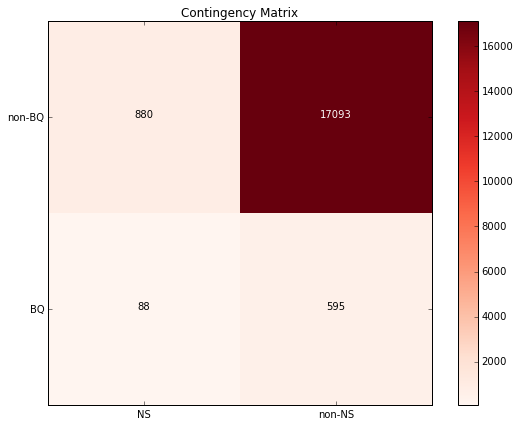

In [27]:
# visualizing the contingency matrix
cm = contingency
fig, ax = plt.subplots(1,1, figsize=(8,6))
cmap = plt.cm.Reds
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title("Contingency Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['NS', 'non-NS'], rotation=0)
plt.yticks(tick_marks, ['non-BQ', 'BQ'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The BQ quadrants (bottom half/second row) are usually the least populated since it's difficult to BQ (and most marathons have far more non-BQs than BQs).

Because the chi-squared value is much greater than the critical value at the 99% confidence level (83 >> 6.635), we can reject the null hypothesis that splits and BQs are uncorrelated.

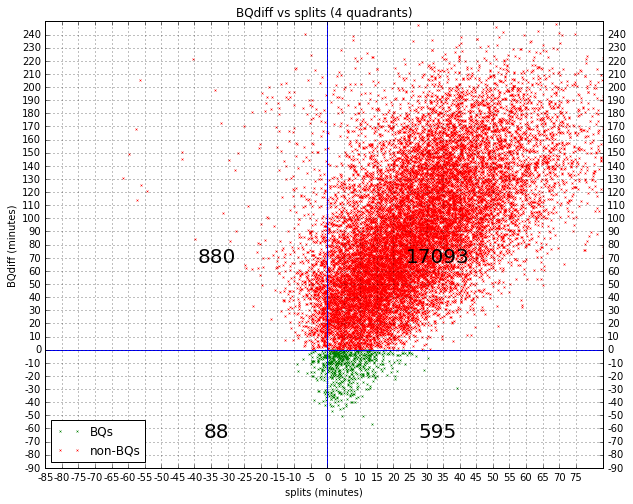

In [28]:
# BQdiff vs splits: visualizing the spread of points across the 4 quadrants
plotthis = True
if plotthis == True:
    fig, ax = plt.subplots(1,1, figsize=(10,8))

    ploty = dfr.query("BQ==1")['BQdiff']
    plotx = dfr.query("BQ==1")['splits']
    ax.plot(plotx,ploty, 'gx', aa=True, markersize=2, label='BQs')

    ploty = dfr.query("BQ==0")['BQdiff']
    plotx = dfr.query("BQ==0")['splits']
    ax.plot(plotx,ploty, 'rx', aa=True, markersize=2, label='non-BQs')

    # ns_bq_y, ns_bq_n, ps_bq_y, ps_bq_n
    plt.text(-2000, -4000, ns_bq_y, size=20, horizontalalignment='center')
    plt.text(-2000, 4000, ns_bq_n, size=20, horizontalalignment='center')
    plt.text(2000, -4000, ps_bq_y, size=20, horizontalalignment='center')
    plt.text(2000, 4000, ps_bq_n, size=20, horizontalalignment='center')
    plt.xlabel("splits (minutes)")
    plt.ylabel("BQdiff (minutes)")
    xlim_range = [-5000, 5000]; ylim_range = [-5000,15000]
    plt.xlim(xlim_range)
    plt.ylim(ylim_range)
    plt.xticks([x*60*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))],[x*5 for x in range(int(np.floor(min(xlim_range)/300.0)),int(np.ceil(max(xlim_range))/300.0))])
    plt.yticks([x*60*10 for x in range(int(np.floor(min(ylim_range)/600.0)),int(np.ceil(max(ylim_range))/600.0))],[x*10 for x in range(int(np.floor(min(ylim_range)/600.0)),int(np.ceil(max(ylim_range))/600.0))])
    ax.tick_params(labeltop=False, labelright=True)
    plt.axhline()
    plt.axvline()
    plt.legend(loc='lower left')
    plt.grid(axis='both')
    plt.title('BQdiff vs splits (4 quadrants)')
    plt.show()

### Pace-related queries

In [29]:
# query: find those who had a split pace that was more than X seconds faster than their overall pace
delta = 70 # seconds
columns_i_want = ['BQ','bib','name','age','chip',halfway,'2ndhalf','pace','mm','non_missing_splitpaces_time','stdpace']
dfr[dfr.apply(lambda row: ((min(row['non_missing_splitpaces']) + delta) 
    < get_sec(row['pace'])),axis=1) == 1].query("BQ==1").sort_values(by='stdpace',ascending=False)[0:60][columns_i_want]

,BQ,bib,name,age,chip,split5_time,2ndhalf,pace,mm,non_missing_splitpaces_time,stdpace
3456,1,28053,KESHAV PADHA,73,4:07:36,,,9:27,"[1, 2, 3, 4, 5, 6, 7]","[8:03, 16:31, 15:40]",279.847209
1387,1,3489,ELIZABETH BUSTANI,47,3:43:26,,,8:31,"[2, 3, 4, 5, 6]","[11:24, 6:49, 11:38, 8:03, 15:16]",199.687891
2077,1,1822,ROBERT DEBSKI,67,3:52:59,,,8:53,"[4, 5, 6, 7]","[12:05, 11:57, 5:17, 7:51, 8:11, 13:46]",193.908083
1239,1,24955,SEAN MURPHY,65,3:40:28,1:30:41,2:09:47,8:25,[2],"[10:11, 4:03, 8:56, 9:00, 9:07, 9:14, 9:51, 10:35, 11:22]",124.670538
780,1,29760,BRYONY BONAVITA,27,3:30:11,1:31:37,1:58:34,8:01,[],"[7:27, 6:47, 6:51, 6:54, 6:56, 7:02, 7:47, 9:16, 10:15, 12:15]",111.196133
1488,1,17328,PATRICIA CLOONEY,45,3:45:06,1:41:42,2:03:24,8:35,[],"[8:31, 7:34, 7:33, 7:29, 7:23, 7:35, 7:45, 8:36, 12:20, 11:39]",109.193470
3639,1,3531,ROGER JENSEN,67,4:09:36,1:50:20,2:19:16,9:31,[],"[8:33, 7:58, 8:16, 8:43, 9:08, 9:11, 9:35, 10:15, 11:53, 13:35]",105.809224
607,1,14157,MIGUEL SANCHEZ-RUANO,50,3:25:38,1:30:45,1:54:53,7:51,[],"[6:57, 6:39, 6:59, 7:02, 7:14, 7:27, 7:01, 8:27, 10:48, 11:10]",99.557762
4585,1,18008,ROBIN STECKLEY,59,4:18:47,1:54:07,2:24:40,9:52,[],"[9:13, 8:12, 8:41, 8:41, 8:48, 9:11, 10:34, 11:02, 12:03, 13:04]",98.697093
1107,1,10403,FRANCIS KUNG'U,54,3:37:51,1:36:30,2:01:21,8:19,[],"[7:30, 6:57, 7:16, 7:37, 7:48, 7:51, 8:10, 9:00, 10:48, 11:17]",89.425483


The above is a good way to find people who fade badly down the stretch -- and also people who had a split pace that was out of line with their cumulative pace.

The first 4 names at the top, all with missing splits, are shown to have done some form of course-cutting in order to achieve their fastest split paces.

But there are a few others who didn't miss any timing mats and still managed to short the course -- Ms. Drosky, Ms. Moses, and Ms. Vibes.

In [30]:
# query: find those who had a split pace that was faster than X minutes
pace_in_sec = 60*5 # pace in seconds/mile
columns_i_want = ['BQ','bib','name','age','chip','pace',halfway,'2ndhalf','mm','non_missing_splitpaces_time','stdpace']
dfr[dfr.apply(lambda row: (min(row['non_missing_splitpaces']) < pace_in_sec),axis=1) == 1][columns_i_want]

,BQ,bib,name,age,chip,pace,split5_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
261,0,6082,JOSEPH ORTH,32,3:11:13,7:18,1:25:55,1:45:18,[],"[4:31, 7:04, 6:55, 6:56, 10:07, 6:58, 7:26, 8:17, 8:37, 9:25]",94.315919
584,0,23687,ALEKSI BERUASHVILI,30,3:25:05,7:49,1:26:17,1:58:48,[],"[4:14, 7:02, 7:21, 7:26, 7:49, 7:48, 8:33, 9:34, 10:02, 9:08]",97.959802
1136,0,23661,YEGOR TEREKHOV,38,3:38:30,8:20,1:30:14,2:08:16,[],"[4:48, 7:17, 7:30, 7:34, 8:39, 8:22, 9:24, 10:43, 10:13, 10:04]",106.232027
1239,1,24955,SEAN MURPHY,65,3:40:28,8:25,1:30:41,2:09:47,[2],"[10:11, 4:03, 8:56, 9:00, 9:07, 9:14, 9:51, 10:35, 11:22]",124.670538
2185,0,23662,OLEKSANDR MALANICH,35,3:54:14,8:56,1:29:43,2:24:31,[],"[4:45, 7:08, 7:33, 7:40, 8:05, 8:08, 9:16, 10:25, 15:39, 11:02]",175.884348
2684,0,20724,KARL HOOD,36,3:59:03,9:07,1:49:10,2:09:53,[],"[8:24, 15:21, 1:28, 8:09, 8:01, 8:41, 9:27, 10:00, 10:59, 10:28]",206.288256
3161,0,26255,AARON AVALOS,36,4:04:08,9:19,,,"[2, 4, 5, 6, 7]","[10:31, 4:29, 10:11, 11:17, 16:09]",248.890415
6698,0,23691,LEVAN KVANCHIANI,33,4:35:32,10:31,1:44:21,2:51:11,[],"[4:23, 7:42, 8:30, 9:52, 14:18, 12:26, 12:37, 13:56, 13:40, 11:47]",193.952484
12245,0,19924,XIANGYING ZHANG,47,5:18:48,12:10,2:42:13,2:36:35,[],"[20:03, 9:33, 10:14, 10:06, 10:23, 10:30, 10:46, 11:59, -1:15:25, 3:36:06]",4385.411282
12505,0,8298,SAM VARVEL,27,5:20:55,12:14,2:19:42,3:01:13,[],"[12:41, 12:53, 4:37, 12:16, 11:25, 13:11, 15:12, 16:22, 9:55, 14:54]",198.472153


Here, we're looking for people who had a split pace faster than 5:00/mi, whether they BQed or not.

There are a few people with split paces that are negative. This means that they likely went over a timing mat twice, and the time recorded by the timing mat was at the wrong juncture in terms of distance travelled by the runner.

We see that Mr Murphy shows up as the only BQer with a fast split pace. It should be fairly obvious that he managed to do so by cutting the course.

In [31]:
# check all paces for select people
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']

# it's possible to BQ with stdpace over X!! 
dfr[dfr['BQ'].isin([1]) & dfr['mm_len'].isin([0])].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want][0:10]

,BQ,bib,name,age,BQreq,chip,split5_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
780,1,29760,BRYONY BONAVITA,27,3:35:00,3:30:11,1:31:37,1:58:34,[],8:01,"[7:27, 6:47, 6:51, 6:54, 6:56, 7:02, 7:47, 9:16, 10:15, 12:15]",111.196133
1488,1,17328,PATRICIA CLOONEY,45,3:55:00,3:45:06,1:41:42,2:03:24,[],8:35,"[8:31, 7:34, 7:33, 7:29, 7:23, 7:35, 7:45, 8:36, 12:20, 11:39]",109.193470
3639,1,3531,ROGER JENSEN,67,4:10:00,4:09:36,1:50:20,2:19:16,[],9:31,"[8:33, 7:58, 8:16, 8:43, 9:08, 9:11, 9:35, 10:15, 11:53, 13:35]",105.809224
2284,1,27864,CONSTANCE DICKEY,51,4:00:00,3:55:15,1:55:25,1:59:50,[],8:58,"[7:56, 7:51, 9:14, 9:05, 14:00, 9:10, 9:18, 8:45, 8:58, 10:00]",103.820431
607,1,14157,MIGUEL SANCHEZ-RUANO,50,3:30:00,3:25:38,1:30:45,1:54:53,[],7:51,"[6:57, 6:39, 6:59, 7:02, 7:14, 7:27, 7:01, 8:27, 10:48, 11:10]",99.557762
4585,1,18008,ROBIN STECKLEY,59,4:25:00,4:18:47,1:54:07,2:24:40,[],9:52,"[9:13, 8:12, 8:41, 8:41, 8:48, 9:11, 10:34, 11:02, 12:03, 13:04]",98.697093
1107,1,10403,FRANCIS KUNG'U,54,3:40:00,3:37:51,1:36:30,2:01:21,[],8:19,"[7:30, 6:57, 7:16, 7:37, 7:48, 7:51, 8:10, 9:00, 10:48, 11:17]",89.425483
547,1,18235,HOWARD FROST,52,3:30:00,3:24:03,1:34:53,1:49:10,[],7:47,"[7:33, 7:02, 7:15, 7:06, 7:18, 7:07, 7:20, 7:39, 9:32, 11:34]",88.143216
1734,1,6201,MARIE WHITE,44,3:55:00,3:48:47,1:48:53,1:59:54,[],8:44,"[8:03, 7:51, 8:07, 8:13, 12:47, 8:28, 8:50, 9:13, 9:40, 9:45]",87.608901
3497,1,24048,LINDA DROSKY,54,4:10:00,4:08:03,1:57:59,2:10:04,[],9:28,"[9:07, 8:42, 8:59, 9:06, 9:22, 10:57, 10:42, 11:02, 6:42, 11:09]",83.905447


Here, we're looking for BQers with no missing mats, sorted by descending stdpace.

This is a way to see how badly one can fade and still BQ.

We also see Ms. Drosky again, with her anomalous split pace from 35K to 40K driving her stdpace value upward. Later on, we'll search for other BQers who recorded their fastest split at the same section of the course, to see if that's a common place for course-cutting.

### Runners ahead or behind of BQ pace at all timing mats

Here, we're looking at the number of people who are ahead or behind (in terms of BQ pace) at the timing mats who *eventually fade from BQ pace or "come back" to BQ*.

A BQ runner will show up in one of the *_BQ* columns. He might go from *ahead_BQ* at timing mat #1, to *behind_BQ* at timing mat #2, to *unknown_BQ* at timing mat #3, but he would never add to the *_fade* tallies. In every row, the sum of *ahead_BQ, behind_BQ, unknown_BQ* will always equal the total number of BQs at the race.

(*unknown_BQ* and *u_fade* reflect the number of BQs and non-BQs who have missing splits at that timing mat location.)

By the same logic, a non-BQ runner will always appear under one of the *_fade* columns. The "fade" part isn't entirely accurate, as those who start behind BQ pace and stay behind never actually "fade". Here, I'm using "fade" as a synonym for "non-BQ".

In [32]:
# breakdown of those ahead/behind pace at timing mats
df = dfr
location = []
ahead_pace = []; ahead_fade = []
behind_pace = []; behind_fade = []
unknown_pace = []; unknown_fade = []
for i in timingmats.keys()[0:-1]:
    text = 'split' + str(i) + '_score'
    location.append(timingmats[i])
    ahead_pace.append(df[df[text] <= 0]['BQ'].sum())
    behind_pace.append(df[df[text] > 0]['BQ'].sum())
    unknown_pace.append(df[df[text].isnull()]['BQ'].sum())
    ahead_fade.append(len(df[df[text] <= 0].query("BQ==0")))
    behind_fade.append(len(df[df[text] > 0].query("BQ==0")))
    unknown_fade.append(len(df[df[text].isnull()].query("BQ==0")))
d = {'location': location, 'ahead_BQ': ahead_pace, 'behind_BQ': behind_pace, 'unknown_BQ': unknown_pace,
    'a_fade': ahead_fade, 'b_fade': behind_fade, 'u_fade': unknown_fade}
cols = ['location','ahead_BQ','behind_BQ','unknown_BQ','a_fade','b_fade','u_fade']
BQbreakdown = pd.DataFrame(d, columns=cols, index=range(1,len(mats)))
BQbreakdown['behind_BQpct'] = BQbreakdown.apply(lambda row: "{:.3%}".format(row['behind_BQ']*1.0/dfr['BQ'].sum()),axis=1)
BQbreakdown['a_fadepct'] = BQbreakdown.apply(lambda row: "{:.3%}".format(row['a_fade']*1.0/(row['ahead_BQ']+row['a_fade'])),axis=1)
BQbreakdown['BQoptimal'] = BQbreakdown.apply(lambda row: "{:.3%}".format((dfr.BQ.sum()+row['a_fade'])*1.0/len(dfr)),axis=1)
BQbreakdown['movement'] = BQbreakdown.apply(lambda row: "{:.3%}".format((row['behind_BQ']+row['a_fade'])*1.0/(row['ahead_BQ']+row['behind_BQ']+row['a_fade']+row['b_fade'])),axis=1)
BQbreakdown

,location,ahead_BQ,behind_BQ,unknown_BQ,a_fade,b_fade,u_fade,behind_BQpct,a_fadepct,BQoptimal,movement
1,3.106856,517,156,21,362,18267,796,22.478%,41.183%,5.249%,2.684%
2,6.213712,636,47,11,638,18632,155,6.772%,50.078%,6.621%,3.433%
3,9.320568,665,21,8,664,18608,153,3.026%,49.962%,6.750%,3.432%
4,12.427424,674,8,12,677,18565,183,1.153%,50.111%,6.814%,3.438%
5,13.109375,676,7,11,667,17306,1452,1.009%,49.665%,6.765%,3.613%
6,15.534280,676,6,12,581,18205,639,0.865%,46.221%,6.337%,3.015%
7,18.641136,681,6,7,418,18655,352,0.865%,38.035%,5.527%,2.146%
8,21.747992,685,4,5,230,17117,2078,0.576%,25.137%,4.593%,1.297%
9,24.854848,682,1,11,51,18619,755,0.144%,6.958%,3.703%,0.269%


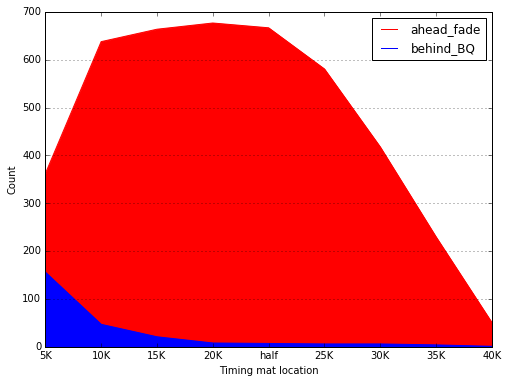

In [33]:
# plotting comebacks & fades
BQbreakdown.a_fade.plot(kind='area',label='ahead_fade',figsize=(8,6), color='r',alpha=1)
BQbreakdown.behind_BQ.plot(kind='area',label='behind_BQ',alpha=1)
#plt.xlim([0.9, 3.1])
plt.xticks(BQbreakdown.index,['5K','10K','15K','20K','half','25K','30K','35K','40K'])
plt.legend()
plt.xlabel("Timing mat location")
plt.ylabel('Count')
plt.grid(which='both',axis='y')
plt.show()

### Magnitude of negative splits

Here, we look at the biggest negative splits for BQs.

We see that no BQers negative-split by more than 10 minutes. (See the *splits_t* column.)

(Recall that, at 2013 St George, the top 10 negative splits were all greater than 12 minutes!)

In [34]:
# biggest negative splits for BQs
columns_i_want = ['BQ','bib', 'name', 'age','chip',halfway,'2ndhalf','behindby',
    'splits_t','BQdiff_t', 'mm','stdpace','non_missing_splitpaces_time']
(dfr.assign(behindby=map(get_time,dfr[halfway.replace("time","score")]*mats[halfway_index]),splits_t=map(get_time,dfr.splits),BQdiff_t=map(get_time,dfr.BQdiff))\
     .query("BQ==1").sort_values(by='splits',ascending=True)[columns_i_want].head(10))

,BQ,bib,name,age,chip,split5_time,2ndhalf,behindby,splits_t,BQdiff_t,mm,stdpace,non_missing_splitpaces_time
1427,1,1893,WILLIAM COOK,63,3:43:58,1:56:31,1:47:27,-0:59,-9:04,-11:02,[],30.611784,"[8:55, 9:04, 9:32, 8:12, 8:14, 8:14, 8:28, 8:03, 8:07, 8:02]"
721,1,12713,BRENDA YAMAJI,40,3:28:45,1:48:43,1:40:02,-3:47,-8:41,-16:15,[],25.808586,"[8:27, 8:25, 8:21, 8:02, 7:57, 7:55, 7:44, 7:33, 7:37, 7:06]"
880,1,22183,KEVIN STUART,57,3:32:42,1:49:56,1:42:46,-0:04,-7:10,-7:18,[],24.200703,"[9:07, 8:10, 8:15, 8:02, 8:16, 7:59, 7:48, 7:42, 7:54, 7:51]"
361,1,20447,SOPHIE NIELSEN,25,3:17:17,1:41:41,1:35:36,-5:49,-6:05,-17:43,[],26.211936,"[8:38, 7:36, 7:32, 7:22, 7:17, 7:21, 7:23, 7:19, 7:15, 7:01]"
4936,1,11015,COLLEEN BALLING,59,4:21:44,2:13:32,2:08:12,1:02,-5:20,-3:16,[],33.629938,"[11:32, 9:43, 9:52, 9:45, 9:44, 9:49, 9:51, 9:39, 9:47, 9:49]"
3418,1,29483,LORI FRENCH,57,4:07:07,2:06:02,2:01:05,1:02,-4:57,-2:53,[],27.135047,"[10:03, 9:17, 9:42, 9:28, 9:20, 10:09, 9:06, 9:03, 9:04, 8:45]"
750,1,8158,KRISTEN CALGARO,36,3:29:26,1:47:11,1:42:15,-2:49,-4:56,-10:34,[],20.085991,"[8:36, 8:03, 8:09, 7:59, 7:49, 7:56, 8:03, 7:45, 7:43, 7:18]"
287,1,24678,FRED PANGAPALAN,50,3:13:03,1:38:59,1:34:04,-6:01,-4:55,-16:57,[],18.442482,"[8:09, 7:29, 7:24, 7:15, 7:16, 7:11, 7:12, 7:06, 7:08, 7:24]"
590,1,5620,CORI MALEY,32,3:25:19,1:44:59,1:40:20,-2:31,-4:39,-9:41,[],16.243994,"[8:28, 7:49, 7:57, 7:51, 7:48, 7:49, 7:45, 7:37, 7:31, 7:32]"
246,1,21895,BAOQING LI,51,3:10:09,1:37:23,1:32:46,-7:37,-4:37,-19:51,[],18.620709,"[7:58, 7:23, 7:19, 7:07, 7:08, 7:00, 7:01, 6:54, 7:11, 7:30]"


### BQ misses (close calls)

In [35]:
# people who faded from BQs at halfway (sorted by closest misses)
columns_i_want = ['name','age','BQreq','chip','BQdiff_t',halfway,'2ndhalf','splits_t','aheadby','stdpace','mm','non_missing_splitpaces_time']
dfr.assign(splits_t=map(get_time,dfr.splits), BQdiff_t=map(get_time,dfr.BQdiff), aheadby=map(get_time,-dfr[halfway.replace("time","score")]*mats[halfway_index]))\
    [dfr['BQ'].isin([0]) & (dfr[halfway.replace("time","score")]<=0)].sort_values(by='BQdiff')[columns_i_want][0:20]

,name,age,BQreq,chip,BQdiff_t,split5_time,2ndhalf,splits_t,aheadby,stdpace,mm,non_missing_splitpaces_time
325,RICHARD PLUMMER,40,3:15:00,3:15:03,0:03,1:36:41,1:38:22,1:41,0:49,13.344910,[],"[7:43, 7:10, 7:20, 7:17, 7:23, 7:18, 7:20, 7:29, 7:42, 7:51]"
1495,RANA JAAFAR,40,3:45:00,3:45:10,0:10,1:50:39,1:54:31,3:52,1:51,26.748539,[],"[9:23, 8:00, 8:14, 8:10, 8:19, 8:50, 8:28, 8:36, 9:10, 8:30]"
1500,JAY HAIRSINE WILSON,40,3:45:00,3:45:13,0:13,1:46:14,1:58:59,12:45,6:16,50.392268,[],"[8:53, 7:51, 7:52, 7:50, 8:01, 8:07, 8:28, 9:33, 9:31, 10:06]"
589,SEAN CAMPBELL,47,3:25:00,3:25:17,0:17,1:40:25,1:44:52,4:27,2:05,15.481077,[],"[7:44, 7:24, 7:51, 7:38, 7:48, 7:47, 7:58, 7:53, 8:12, 8:16]"
1509,WENDY ABBOTT,43,3:45:00,3:45:17,0:17,1:50:54,1:54:23,3:29,1:36,16.078603,[],"[8:46, 8:25, 8:21, 8:19, 8:24, 8:23, 9:03, 8:27, 8:55, 8:47]"
787,DAVID HANDEL,52,3:30:00,3:30:22,0:22,1:43:18,1:47:04,3:46,1:42,29.058408,[],"[8:40, 7:33, 7:45, 7:36, 7:39, 7:43, 7:47, 8:04, 8:50, 8:32]"
594,STEPHEN SPONSELLER,45,3:25:00,3:25:23,0:23,1:40:53,1:44:30,3:37,1:37,33.435436,[],"[8:19, 7:32, 7:39, 7:23, 7:20, 7:20, 7:31, 7:52, 8:40, 8:48]"
1237,LABECCA BUSELLI,34,3:40:00,3:40:25,0:25,1:45:56,1:54:29,8:33,4:04,25.445635,[],"[8:11, 7:57, 8:07, 8:03, 8:08, 8:15, 8:32, 8:43, 9:15, 8:53]"
2301,DON MUELLER,59,3:55:00,3:55:26,0:26,1:52:56,2:02:30,9:34,4:34,36.186917,[],"[9:12, 8:24, 8:27, 8:23, 8:42, 8:42, 9:03, 9:15, 9:55, 10:03]"
995,MEGAN WEBER,25,3:35:00,3:35:28,0:28,1:43:19,1:52:09,8:50,4:11,28.081762,[],"[7:59, 7:48, 7:58, 7:48, 7:48, 8:08, 8:20, 8:29, 8:59, 9:01]"


In [36]:
# these are the runners classified as "easy" who missed their BQs by the least
columns_i_want = ['BQ','name','age','BQreq','chip','BQdiff_t','pace',tenK.replace("time","score"),halfway.replace("time","score"),halfway,'2ndhalf','splits_t','behindby','stdpace','mm','non_missing_splitpaces_time']
easy.assign(splits_t=map(get_time,easy.splits),BQdiff_t = map(get_time,easy.BQdiff),behindby=map(get_time,easy[halfway.replace("time","score")]*mats[halfway_index])).sort_values(by='BQdiff').head(10)[columns_i_want]

,BQ,name,age,BQreq,chip,BQdiff_t,pace,split2_score,split5_score,split5_time,2ndhalf,splits_t,behindby,stdpace,mm,non_missing_splitpaces_time
2277,0,KAREN ROE,48,3:55:00,3:55:10,0:10,8:58,NaN,NaN,,,,,50.530059,"[1, 2, 3, 4, 5, 6, 8, 9]","[8:38, 9:49]"
2294,0,KELLEY DUELL,46,3:55:00,3:55:24,0:24,8:59,NaN,NaN,,,,,33.361597,"[2, 4, 5, 6]","[9:13, 8:35, 8:46, 8:55, 9:52, 9:52]"
1005,0,KATHERINE HEKKER,26,3:35:00,3:35:39,0:39,8:14,21.688296,11.899881,1:50:06,1:45:33,-4:33,2:36,25.598105,[],"[9:02, 8:05, 8:27, 8:05, 8:07, 8:05, 8:16, 8:05, 8:07, 7:18]"
262,0,JEFFREY RUANE,35,3:10:00,3:11:16,1:16,7:18,25.790910,12.967819,1:37:50,1:33:26,-4:24,2:50,18.711124,[],"[8:08, 7:13, 7:18, 7:14, 7:20, 7:15, 7:09, 7:00, 7:08, 7:07]"
2398,0,BOB ROBERTSON,59,3:55:00,3:56:34,1:34,9:01,41.580758,12.586412,2:00:15,1:56:19,-3:56,2:45,34.769473,[],"[10:08, 9:11, 8:56, 8:34, 8:36, 8:32, 8:39, 8:44, 9:00, 9:59]"
1085,0,MICHELLE RILEY,25,3:35:00,3:37:18,2:18,8:17,29.413147,11.060787,1:49:55,1:47:23,-2:32,2:25,16.044402,[],"[8:57, 8:26, 8:07, 8:06, 8:08, 8:07, 8:13, 8:03, 8:16, 8:24]"
1652,0,ERIN PORTER,39,3:45:00,3:47:27,2:27,8:41,27.450232,10.984505,1:54:54,1:52:33,-2:21,2:24,19.463625,[],"[9:30, 8:35, 8:35, 8:28, 8:29, 8:26, 8:32, 8:34, 8:37, 8:57]"
2526,0,VESNA ZAIMOVIC,45,3:55:00,3:57:46,2:46,9:04,34.338710,22.579261,2:02:26,1:55:20,-7:06,4:56,23.699727,[],"[9:58, 9:06, 9:29, 8:53, 8:58, 8:49, 8:52, 8:43, 8:49, 8:45]"
2573,0,SANDY MIKOLAITIES,47,3:55:00,3:58:09,3:09,9:05,22.751433,6.407628,1:58:54,1:59:15,0:21,1:24,31.813505,[],"[9:59, 8:42, 9:02, 8:41, 8:32, 8:42, 8:51, 8:54, 9:29, 9:55]"
2585,0,DENNIS SAYE,63,3:55:00,3:58:16,3:16,9:05,22.751433,9.916567,1:59:40,1:58:36,-1:04,2:10,16.826167,[],"[9:47, 8:54, 9:05, 8:46, 9:04, 9:05, 9:02, 8:51, 9:12, 9:05]"


###  Missing splits (timing mat anomalies)

Timing mats don't always detect runners' RFID tags as they go by.

Different races have varying degrees of timing mats not detecting runners. At MCM, this is a widespread issue.

Here, we take a look at the numbers of missing splits, where they occurred, and which BQ runners had missing splits.

By now, you've probably figured out that "mm" stands for "missing mats", and "mm_len" represents len(mm). If a runner has mm = [1], that means that she has a missing first split.

In [37]:
# missing mats
print(dfr['mm_len'].value_counts().sort_index())
print(len(dfr[dfr.mm_len>0]))
print("{:.2%} of {} finishers had at least 1 missing split".format(len(dfr[dfr.mm_len>0])*1.0/len(dfr), len(dfr)))

0    15027
1     4158
2      635
3      154
4       63
5       26
6       20
7       23
8        9
9        4
Name: mm_len, dtype: int64
5092
25.31% of 20119 finishers had at least 1 missing split


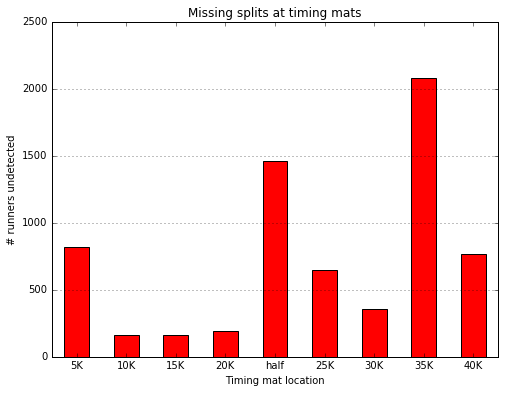

In [38]:
#plt.style.use("default") # default, classic, seaborn-white, ggplot, fivethirtyeight, ...
missingmats_dict = {}
for x in range(1,len(timingmats)):
    missingmats_dict[timingmats[x]] = dfr.apply(lambda row: 1 if x in row['mm'] else 0,axis=1).sum()
pd.Series(missingmats_dict).plot.bar(rot=0, figsize=(8,6),color='r')
plt.xlabel("Timing mat location")
plt.ylabel("# runners undetected")
plt.title("Missing splits at timing mats")
plt.xticks(range(9), ['5K','10K','15K','20K','half','25K','30K','35K','40K'])
plt.grid(which='both',axis='y')
plt.show()

In [39]:
# check all paces for BQs with missing splits
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']
print(len(dfr[dfr['BQ'].isin([1]) & (dfr['mm_len']>0)]))
(dfr[dfr['BQ'].isin([1]) & (dfr['mm_len']>0)].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want][0:])

47


,BQ,bib,name,age,BQreq,chip,split5_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
3456,1,28053,KESHAV PADHA,73,4:25:00,4:07:36,,,"[1, 2, 3, 4, 5, 6, 7]",9:27,"[8:03, 16:31, 15:40]",279.847209
731,1,20552,HARRY LINDE,58,3:40:00,3:29:07,,,"[1, 4, 5, 6, 7, 8, 9]",7:59,"[8:55, 8:50, 7:28]",48.553947
32,1,7363,ANTHONY MAYNARD,43,3:15:00,2:43:32,,,"[1, 2, 4, 5, 6, 7, 9]",6:14,"[6:26, 5:53, 6:48]",27.498167
40,1,155,SARAH BISHOP,35,3:40:00,2:45:07,,,"[1, 2, 3, 4, 5, 7, 9]",6:18,"[6:16, 6:16, 6:27]",6.563910
1387,1,3489,ELIZABETH BUSTANI,47,3:55:00,3:43:26,,,"[2, 3, 4, 5, 6]",8:31,"[11:24, 6:49, 11:38, 8:03, 15:16]",199.687891
1764,1,28044,DAYUE CHEN,59,3:55:00,3:49:14,1:51:36,1:57:38,"[1, 4, 6, 8, 9]",8:45,"[8:53, 8:13, 8:09, 8:32, 9:18]",28.683776
2077,1,1822,ROBERT DEBSKI,67,4:10:00,3:52:59,,,"[4, 5, 6, 7]",8:53,"[12:05, 11:57, 5:17, 7:51, 8:11, 13:46]",193.908083
2233,1,1811,TERESA KLEIN,56,4:10:00,3:54:43,1:57:10,1:57:33,"[3, 4, 6, 9]",8:57,"[10:41, 8:27, 8:22, 8:27, 9:07, 9:31]",53.826570
200,1,25911,NATALIE HOPKINS,28,3:35:00,3:05:51,,,"[1, 2, 3, 5]",7:05,"[7:10, 7:03, 7:04, 6:50, 7:04, 7:10]",7.353593
1106,1,4097,ELIZABETH MCGRATH,53,4:00:00,3:37:51,1:38:39,1:59:12,"[1, 2, 3]",8:19,"[7:29, 8:26, 8:33, 8:50, 9:09, 9:25, 9:47]",45.283928


There are 47 BQers who had at least 1 missing split.

We have to eyeball the *mm* column to see which timing mats they missed, along with the *non_missing_splitpaces_time* column to see what their paces looked like in between any missing mats.

Let's make a note of the suspicious cases above, by bib numbers:
- 28053 (missing first 7 mats)
- 20552 (missing lots of mats, fast pace between 15K & finish)
- 3489 (fast pace between 5K & 30K)
- 1822 (5:17/mi between 10K & 15K)
- 4097 (missing first 3 mats)
- 24955 (4:03/mi between 5K & 15K)

It's important to point out that some runners had lots of missing splits but are what I consider "too fast to cheat". For example, bib #155 had 7 missing splits, including the first 5, but she was the female winner of the race, in 2:45:07. Her story has been __[well](https://www.washingtonpost.com/sports/nine-days-ago-she-pleaded-to-join-the-marine-corps-marathon-sunday-she-came-in-first/2017/10/22/d5a5bb96-b750-11e7-be94-fabb0f1e9ffb_story.html?tid=hybrid_experimentrandom_2_na&utm_term=.962f11f8cb79)__-__[publicized](https://www.runnersworld.com/marine-corps-marathon/marathon-winning-mom-of-four-busts-the-no-time-myth)__ and there's no reason to think that she cut the course anywhere.

Let's take a closer look at one of the suspicious cases and explain how to interpret the *non_missing_splitpaces_time* column when *mm* is not [] --

In [40]:
# explaining a suspicious case's splits
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']
(dfr[dfr['bib'].isin([3489])][columns_i_want])

,BQ,bib,name,age,BQreq,chip,split5_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
1387,1,3489,ELIZABETH BUSTANI,47,3:55:00,3:43:26,,,"[2, 3, 4, 5, 6]",8:31,"[11:24, 6:49, 11:38, 8:03, 15:16]",199.687891


We see that this person has *mm*=[2,3,4,5,6].

This means that she missed 5 timing mats: #2-6. (Or the timing mats missed her, as in the case of the female winner.)

These timing mats correspond to the second through sixth entries of *mats*: 10K, 15K, 20K, half, 25K

She has 5 entries in *non_missing_splitpaces_time*:
- 11:24/mi between the start and timing mat #1 (5K)
- 6:49/mi between timing mat #1 (5K) and timing mat #7 (30K)
- 11:38/mi between timing mat #7 (30K) and timing mat #8 (35K)
- 8:03/mi between timing mat #8 (35K) and timing mat #9 (40K)
- 15:16/mi between timing mat #9 (40K) and the finish (42.2K)

This should be considered a *very* suspicious case due to the fast split pace of 6:49/mi, relative to her overall pace of 8:31/mi, across a long stretch of missed mats (between 5K and 30K).

Let's take a look at a more difficult example to explain --

In [41]:
# explaining a suspicious case's splits
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']
(dfr[dfr['bib'].isin([1811])][columns_i_want])

,BQ,bib,name,age,BQreq,chip,split5_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
2233,1,1811,TERESA KLEIN,56,4:10:00,3:54:43,1:57:10,1:57:33,"[3, 4, 6, 9]",8:57,"[10:41, 8:27, 8:22, 8:27, 9:07, 9:31]",53.82657


We see that this person has *mm*=[3,4,6,9].

This means that she missed 4 timing mats. (Or the timing mats missed her, as in the case of the female winner.)

These timing mats correspond to the third, fourth, sixth, and ninth entries of *mats*: 15K, 20K, 25K, and 40K.

She has 6 entries in *non_missing_splitpaces_time*:
- 10:41/mi between the start and timing mat #1 (5K)
- 8:27/mi between timing mat #1 (5K) and timing mat #2 (10K)
- 8:22/mi between timing mat #2 (10K) and timing mat #5 (halfway)
- 8:27/mi between timing mat #5 (halfway) and timing mat #7 (30K)
- 9:07/mi between timing mat #7 (30K) and timing mat #8 (35K)
- 9:31/mi between timing mat #8 (35K) and the finish (42.2K)

This should be considered a *somewhat* suspicious case due to the fast split pace of 8:22/mi, relative to her overall pace of 8:57/mi, across a stretch of missed mats (between 10K and 21.1K). It's always suspicious when a runner has her fastest split pace over a stretch that includes missing mats.


24955 3:40:28 M65_69 SEAN MURPHY [2] ['10:11', '6:06', '6:48', '6:55', '7:16', '7:35', '7:55', '8:15', '8:25']
3489 3:43:26 F45_49 ELIZABETH BUSTANI [2, 3, 4, 5, 6] ['11:24', '7:35', '8:10', '8:09', '8:31']
1822 3:52:59 M65_69 ROBERT DEBSKI [4, 5, 6, 7] ['12:05', '12:01', '9:47', '8:41', '8:37', '8:53']
1811 3:54:43 F55_59 TERESA KLEIN [3, 4, 6, 9] ['10:41', '9:34', '8:56', '8:48', '8:50', '8:57']
28053 4:07:36 M70_74 KESHAV PADHA [1, 2, 3, 4, 5, 6, 7] ['8:03', '9:06', '9:27']
11015 4:21:44 F55_59 COLLEEN BALLING [] ['11:32', '10:37', '10:22', '10:13', '10:11', '10:08', '10:05', '10:01', '10:00', '9:59']


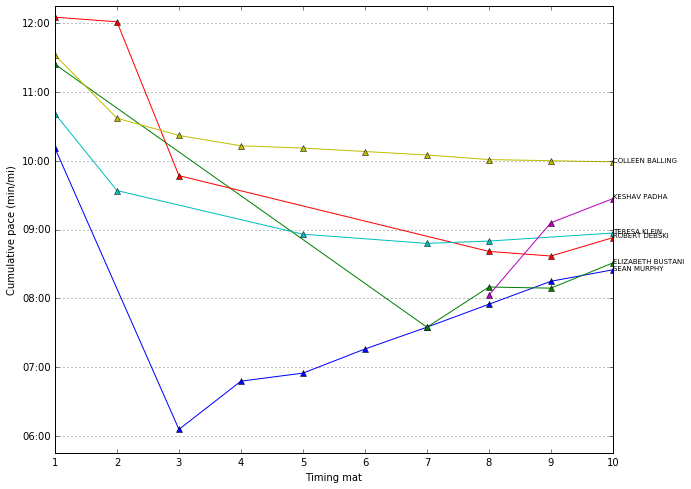

In [42]:
# plot average paces at timing mats (including finish line)
# for those who BQed and had a cumulative pace differential of greater than X seconds
# (one way to find cheaters!!)

differential = 75

fig, ax = plt.subplots(1,1, figsize=(10,8))

for x in range(len(dfr)):
    if dfr.iloc[x]['BQ'] == 1 and (max(dfr.iloc[x]['non_missing_cumpaces']) - min(dfr.iloc[x]['non_missing_cumpaces']) > differential) :
        print dfr.iloc[x]['bib'], dfr.iloc[x]['chip'], dfr.iloc[x]['DIVISION'], dfr.iloc[x]['name'], dfr.iloc[x]['mm'], map(get_time,dfr.iloc[x]['non_missing_cumpaces'])
        ax.plot(dfr.iloc[x]['non_missing_mats'], mdates.epoch2num(dfr.iloc[x]['non_missing_cumpaces']), '^-' )
        ax.text(dfr.iloc[x]['non_missing_mats'][-1], mdates.epoch2num(dfr.iloc[x]['non_missing_cumpaces'])[-1], dfr.iloc[x]['name'], size = 7)
ax.yaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
ax.yaxis.set_major_locator(mdates.MinuteLocator(interval=1))
ax.grid(which='both',axis='y')
plt.xlabel("Timing mat")
plt.ylabel("Cumulative pace (min/mi)")
plt.show()

Except for Ms. Balling, none of the names are new.

With this query, we're trying to find people whose cumulative paces varied a great deal during the course of the run. The query plots those who fade badly or who improve greatly -- Ms. Balling falls into the latter category -- and also those cut the course too aggressively.

We can adjust *differential* to visually see more cases, but next, we'll find those who ran their fastest from 35K-40K --

In [43]:
# find BQers whose fastest split was between 35K-40K (fastest_split==9)
columns_i_want = ['BQ','bib', 'name', 'age','chip','pace',halfway,'2ndhalf',
    'mm','stdpace','non_missing_splitpaces_time']
(dfr[dfr.BQ.isin([1]) & (dfr.fastest_split==9)].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want].head(60))

,BQ,bib,name,age,chip,pace,split5_time,2ndhalf,mm,stdpace,non_missing_splitpaces_time
3497,1,24048,LINDA DROSKY,54,4:08:03,9:28,1:57:59,2:10:04,[],83.905447,"[9:07, 8:42, 8:59, 9:06, 9:22, 10:57, 10:42, 11:02, 6:42, 11:09]"
621,1,14936,ALEXANDRA MOSES,30,3:25:59,7:51,1:40:44,1:45:15,[],63.276923,"[8:13, 7:32, 7:42, 7:22, 7:21, 7:36, 8:19, 8:31, 6:31, 10:28]"
757,1,15184,KIMBERLEY VIBES,22,3:29:32,8:00,1:45:08,1:44:24,[],62.015235,"[8:26, 7:49, 7:53, 7:56, 8:07, 8:08, 8:21, 8:52, 5:43, 9:51]"
2123,1,3307,TAMMY GERBER,46,3:53:29,8:54,1:55:05,1:58:24,[],35.261299,"[9:15, 8:26, 8:51, 8:36, 8:41, 8:54, 9:14, 9:41, 7:54, 9:52]"
590,1,5620,CORI MALEY,32,3:25:19,7:50,1:44:59,1:40:20,[],16.243994,"[8:28, 7:49, 7:57, 7:51, 7:48, 7:49, 7:45, 7:37, 7:31, 7:32]"


The first 3 ladies were found earlier.

Ms. Gerber also appears to have short-changed that section but went undetected earlier due to her (relatively) low stdpace value of 35.

Nothing appears abnormal about the split paces for the last runner, who managed to negative-split by 4 minutes and saved her best running for last.

#### Past history

Here, we'll try to find cheaters based on incongruencies with their recent marathoning history.

I've written __[blog](https://dunkemo.wordpress.com/2017/10/30/reviewing-2017-mcm-results/)__ __[posts](https://dunkemo.wordpress.com/2017/08/02/finding-marathon-cheaters-based-on-past-race-results/)__ about this before, and now we'll show how we go about using our database to find marathon times run by MCM runners.

First, we'll get all the BQers and possible BQers and put them into a *bqs* dataframe.

In [44]:
# First, find BQs by people who might "age up" between this race & qualifying BOS race
# These are people who have BQ==0 but still might have BQed depending on their birthdate
# For example, a 33-year-old (in OCT 2017) with a March birthdate will be 35 in APR 2019
# So, we're trying to find "possible BQs" who are assumed to be non-BQs

columns_i_want = ['name','age','DIVISION','BQreq','chip',halfway,'2ndhalf','mm','non_missing_splitpaces_time','stdpace']
offset = 1+ageUp

possibles1 = dfr[(dfr['age'].isin((x-offset) for x in [35,40,50])) & (dfr['BQdiff'] <= 60*5) & (dfr['BQ'] == 0) ]
possibles2 = dfr[(dfr['age'].isin((x-offset) for x in [45,55])) & (dfr['BQdiff'] <= 60*10) & (dfr['BQ'] == 0) ]
possibles3 = dfr[(dfr['age'].isin((x-offset) for x in [60,65,70,75])) & (dfr['BQdiff'] <= 60*15) & (dfr['BQ'] == 0) ]
print(len(possibles1))
print(len(possibles2))
print(len(possibles3))
possibles = pd.concat([possibles1,possibles2,possibles3])
possibles.sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want]

23
17
14


,name,age,DIVISION,BQreq,chip,split5_time,2ndhalf,mm,non_missing_splitpaces_time,stdpace
2277,KAREN ROE,48,F45_49,3:55:00,3:55:10,,,"[1, 2, 3, 4, 5, 6, 8, 9]","[8:38, 9:49]",50.530059
1168,GILLES PARIS,53,M50_54,3:30:00,3:39:09,1:45:43,1:53:26,"[1, 7]","[8:18, 7:53, 7:48, 7:52, 7:43, 8:39, 8:58, 9:36]",40.401971
3227,STUART SMITH,53,F50_54,4:00:00,4:04:49,1:54:36,2:10:13,[1],"[8:44, 8:42, 8:46, 8:58, 9:03, 9:17, 9:39, 10:43, 11:48]",64.124749
3986,JANET RUMER,58,F55_59,4:10:00,4:13:08,2:00:42,2:12:26,[1],"[9:15, 9:05, 9:14, 9:17, 9:16, 9:37, 10:14, 10:40, 11:06]",44.000137
1796,SCOTT WHITTINGTON,58,M55_59,3:40:00,3:49:42,1:52:35,1:57:07,[1],"[8:37, 8:22, 8:47, 8:29, 8:14, 8:35, 8:19, 10:13, 9:27]",38.920382
901,SCOTT LAWRENCE,53,M50_54,3:30:00,3:33:10,1:39:00,1:54:10,[],"[7:53, 7:24, 7:29, 7:26, 7:36, 7:34, 7:38, 8:01, 9:19, 13:21]",110.247988
2832,LUTHER ISAAC,63,M60_64,3:55:00,4:00:18,1:48:33,2:11:45,[],"[8:33, 8:03, 8:18, 8:12, 8:19, 8:22, 8:38, 9:34, 12:40, 11:26]",94.733009
4480,ANN HYNES,58,F55_59,4:10:00,4:17:49,1:58:38,2:19:11,[],"[9:02, 9:01, 9:10, 8:59, 9:04, 9:15, 9:56, 11:17, 11:01, 12:08]",69.893885
6922,DONALD HENSEL,73,M70_74,4:25:00,4:37:20,2:06:09,2:31:11,[],"[9:53, 9:08, 9:34, 9:47, 10:13, 10:21, 11:21, 12:11, 11:53, 11:44]",65.225422
6331,MARY ANNE LYNCH,63,F60_64,4:25:00,4:32:44,2:07:22,2:25:22,[],"[9:59, 9:33, 9:45, 9:39, 9:20, 9:37, 11:41, 10:46, 11:25, 12:20]",63.673513


In [45]:
bqs = dfr[(dfr.BQ == 1) | dfr.bib.isin(possibles['bib'])].copy()
bqs.reset_index(drop=True,inplace=True)
bqs['name'] = bqs['name'].str.upper().str.strip()
print(len(bqs))

748


Next, we fire up our mongodb database and search for each MCM runner in *bqs* --

In [46]:
import pymongo
from pymongo import MongoClient
client = MongoClient('localhost:27017')
db = client.examples
races = db.mg # mg for "Marathon Guide"

In [47]:
# with a race's entrants list, search the database for each name, pull each entrant's recent results
counter = 0
exact_ages = True
race_date = "2017-10-22"
daterange_start = str(int(race_date[0:4])-3) + "-01-01" # 3+ years prior to race_date
bqs['races'] = ''

for name in bqs['name'][0:]:

    times = []

    cursor = races.find({"namemod": {"$regex": "^" + name}, "race_date": {"$gte": daterange_start, "$lt": race_date} } )
    
    for x in cursor:
        addthis = []; marker = ""
        if x['namemod'] != name:
            marker = "~"
        yrs_between_races = (pd.to_datetime(race_date,format="%Y-%m-%d") - pd.to_datetime(x['race_date'],format="%Y-%m-%d")).days*1.0/365

        if np.isnan(x['age']):
            # if age is nan, then have to add it
            if "DIV" in x.keys():
                age = x['DIV']

                try:
                    # it's possible that x['DIV'] is nan
                    np.isnan(age)
                    age = ""
                    # if age is nan, then nothing happens: except block gets skipped
                except:
                    # usual format: F30-34, M0-19, M25-29, etc
                    if age[-2:].isdigit():
                        age_upperlim = int(age[-2:])
                        if age[-5:-3].isdigit():
                            age_lowerlim = int(age[-5:-3])
                        else:
                            # the case when there's a pesky zero: M0-19, M0-39, etc
                            age_lowerlim = 0
                        if exact_ages == True:
                            if bqs['age'][counter] in range(age_lowerlim,age_upperlim+int(np.ceil(yrs_between_races))+1):
                                pass
                            else:
                                continue
                    else:
                        pass
            else:
                age = ""
        else:
            # if the document has age, then check if it's in the range
            age = int(x['age'])

            if exact_ages == True:
                if ~((bqs['age'][counter] <= (age+0.99+yrs_between_races)) and (bqs['age'][counter] >= np.floor(age+yrs_between_races))):
                    continue
                    
        for field in ['chip','time']:
            try:
                np.isnan(x[field])
                # if chip is nan, then nothing happens: except block gets skipped
            except:
                # if chip is not nan, then add it to addthis
                if x[field][2] == ":": 
                    # chip times of 10 hours or more are not added
                    continue
                elif (("race_city" in x.keys()) and ("USA" not in x['race_city']) and ("Canada" not in x['race_city'])):
                    continue
                else:
                    addthis.append(x[field])

        if len(addthis) > 0:
            # it might be the case that chip & time are both nan; if so, then nothing gets added to times
            trimmed_race_name = x['race_name'].replace(" Marathon","") if x['race_name'].endswith(" Marathon") else x['race_name']
            times.append({min(addthis) + " " + marker + " " + str(age) : trimmed_race_name})
    
    counter += 1
    if counter % 100 == 0:
        print counter
    if len(times)>0:
        bqs.set_value(counter-1,'races',sorted(times))
print("finished!")
bqs['gap'] = bqs.apply(lambda row: get_sec(row['chip']) - get_sec(row['races'][0].keys()[0].split(" ")[0]) if row['races']!=""
                       else "", axis=1)
bqs['gap_t'] = bqs.gap.apply(get_time)

100
200
300
400
500
600
700
finished!


What we did in the above is to search our database with each of the names in *bqs*.

Arbitrarily, we picked 3+ years as the timeframe to search by: everything from JAN 2014 up to 2017 MCM in OCT 2017.

For each record found -- and we're searching for exact names -- we check the age of the runner in that race and see if it's possible that the MCM runner could have been the same person; if not, then we skip to the next record.

If an MCM runner has 5+ records of past races, we keep the fastest 5 and put that into the *races* column, sorted by fastest times first.

*gap* and *gap_t* are the difference (in seconds, and (HH:)MM:SS format) between the fastest prior race and 2017 MCM.

*races* is a list and each entry has the following format: {chip age: race}; if our database search didn't return any records for the MCM runner, then *races/gap/gap_t* are empty strings.

Let's take a look at the biggest improvements made by MCM runners over the past 3+ years --

In [48]:
pd.set_option('max_colwidth',240)
columns_i_want = ['bib','name','age','BQreq','chip','races','gap_t','stdpace','mm','non_missing_splitpaces_time']
bqs[(bqs.gap!="") | bqs.bib.isin(possibles.bib)].sort_values(by='gap')[columns_i_want][0:50]

,bib,name,age,BQreq,chip,races,gap_t,stdpace,mm,non_missing_splitpaces_time
156,4840,KEVIN CUNNINGHAM,28,3:05:00,3:01:42,[{u'5:07:48 M25-29': u'2014 Toronto'}],-2:06:06,23.448934,[],"[6:55, 6:43, 6:45, 6:46, 6:48, 6:40, 6:49, 6:50, 7:33, 7:49]"
583,3489,ELIZABETH BUSTANI,47,3:55:00,3:43:26,[{u'5:36:37 45': u'2015 Chicago'}],-1:53:11,199.687891,"[2, 3, 4, 5, 6]","[11:24, 6:49, 11:38, 8:03, 15:16]"
387,29013,AMY DAVIS,32,3:35:00,3:25:48,"[{u'5:17:28 ': u'2014 Chosen: Marathon for Adoption'}, {u'6:44:23 F20-29': u'2014 Porcupine Mountains Trail'}]",-1:51:40,19.552694,[],"[7:40, 7:27, 7:43, 7:36, 7:42, 7:41, 7:56, 8:09, 8:22, 8:22]"
118,5433,JASON BLACK,23,3:05:00,2:58:26,"[{u'4:31:26 21': u'2016 The North Face Endurance Challenge - Bear Mountain'}, {u'4:54:49 23': u'2017 The North Face Endurance Challenge - Bear Mountain'}]",-1:33:00,20.046013,[],"[7:33, 6:36, 6:45, 6:27, 6:37, 6:33, 6:33, 6:49, 7:06, 6:58]"
733,22617,LISA HOWELL,59,4:25:00,4:17:42,"[{u'5:38:16 55': u'2014 Grandfather Mountain'}, {u'6:19:20 56': u'2015 Grandfather Mountain'}]",-1:20:34,51.489954,[],"[10:00, 9:11, 9:14, 9:15, 9:14, 9:23, 9:32, 10:04, 11:18, 11:27]"
123,28766,ROSS RANKIN,33,3:05:00,2:59:07,"[{u'4:18:35 M30-34': u'2015 Mid Mountain'}, {u'4:29:25 M30-34': u'2016 Mid Mountain'}, {u'4:49:18 M30-39': u'2014 Moab Trail'}]",-1:19:28,23.309634,[],"[6:44, 6:30, 6:37, 6:35, 6:45, 6:44, 6:50, 6:56, 7:18, 7:47]"
305,17791,JESSICA BROWN,26,3:35:00,3:19:33,"[{u'4:31:26 F25-29': u'2014 Phoenix'}, {u'4:55:38 F25-29': u'2014 Rock 'n' Roll Raleigh'}]",-1:11:53,12.514680,[],"[7:55, 7:22, 7:25, 7:24, 7:29, 7:30, 7:40, 7:42, 7:52, 7:49]"
540,24136,MICHAEL SORTINO,57,3:40:00,3:37:20,"[{u'4:40:44 56': u'2016 New York City'}, {u'5:28:15 55': u'2015 New York City'}]",-1:03:24,28.667901,[],"[8:24, 8:08, 8:13, 8:06, 7:40, 7:55, 8:01, 8:01, 9:18, 8:50]"
502,26180,SUSAN CUNDIFF,34,3:40:00,3:34:24,[{u'4:35:03 32': u'2015 Steamboat'}],-1:00:39,26.922574,[],"[9:21, 8:11, 8:07, 7:51, 7:55, 7:49, 8:02, 7:51, 8:11, 8:13]"
344,14226,RACHEL WEIN,26,3:35:00,3:23:01,[{u'4:20:06 25': u'2016 Big Elk'}],-57:05,31.263930,[],"[7:22, 7:16, 7:28, 7:29, 7:21, 7:34, 7:46, 8:06, 8:31, 8:45]"


Most of the top 50 *gap* cases actually don't involve cheaters. There's lots of potential for mismatching names, meaning that our database search might return a hit for a MCM runner that belongs to someone else of the same name and age.

Certainly there are people who improve their marathon times in a short period without cheating. So on our first pass through the above, what we're looking for are MCM runners without common names, and who had multiple slow marathons with a large *gap*.

There are people who had big *gap* values because their prior marathons were on difficult courses (e.g., a race with "Mountain" or "Trail" in its name might be challenging), or were *ultra*marathons (e.g., The North Face Endurance Challenge).

One case is a name we've seen earlier (Ms. Bustani) with missing splits, so it shouldn't come as a surprise that she had a big *gap* as well.

Here are two other cases that we'll highlight --

In [49]:
# 2 specific cases: large gap, multiple slow marathons in recent years
bqs[bqs.bib.isin([24136, 16294])][columns_i_want]

,bib,name,age,BQreq,chip,races,gap_t,stdpace,mm,non_missing_splitpaces_time
360,16294,MOLLY KNIGHT,31,3:35:00,3:24:19,"[{u'4:18:49 29': u'2015 Marine Corps'}, {u'4:43:42 28': u'2014 Marine Corps'}, {u'4:46:33 28': u'2015 Disney World'}]",-54:30,54.704363,[],"[7:51, 7:02, 6:54, 6:57, 7:16, 7:25, 7:59, 8:15, 9:19, 9:21]"
540,24136,MICHAEL SORTINO,57,3:40:00,3:37:20,"[{u'4:40:44 56': u'2016 New York City'}, {u'5:28:15 55': u'2015 New York City'}]",-1:03:24,28.667901,[],"[8:24, 8:08, 8:13, 8:06, 7:40, 7:55, 8:01, 8:01, 9:18, 8:50]"


One can check the __[race](https://www.marathonfoto.com/Proofs?PIN=0CYF13&LastName=Knight)__ __[photos](https://www.marathonfoto.com/Proofs?PIN=0D0001&LastName=Sortino)__ to see that they had people of the opposite sex running with their bibs.

Let's give a similar example --

In [50]:
# another case: large gap, multiple slow marathons in recent years
bqs[bqs.bib.isin([2713])][columns_i_want]

,bib,name,age,BQreq,chip,races,gap_t,stdpace,mm,non_missing_splitpaces_time
608,2713,GREGORY VICKERS,59,3:55:00,3:47:29,"[{u'4:29:55 56': u'2014 Marine Corps'}, {u'4:30:22 58': u'2016 Marine Corps'}]",-42:26,73.519985,[],"[8:03, 7:39, 7:49, 7:57, 8:01, 8:27, 8:45, 9:16, 10:25, 11:20]"


A bib mule might have run for him, and thus explain the large gap, but checking the photos shows that it's the same person who ran MCM in 2014, 2016, and 2017.

This is one disadvantage of looking back only 3+ years. If we go back further, we see that Mr Vickers ran 3:42 at 2012 MCM, which is faster than the 3:47 that he posted at 2017 MCM. Certainly it's harder for older folks to run faster with age, but there are lots of things that we don't know outside of these numbers -- a runner's training, health, and desire to improve.

Let's give another example --

In [51]:
# another case: large gap, only 1 previous race
columns_i_want = ['bib','name','age','BQreq','chip','races','gap_t',halfway,'2ndhalf','stdpace','mm','non_missing_splitpaces_time']
bqs[bqs.bib.isin([11029])][columns_i_want]

,bib,name,age,BQreq,chip,races,gap_t,split5_time,2ndhalf,stdpace,mm,non_missing_splitpaces_time
85,11029,EVAN FALLOR,26,3:05:00,2:53:50,[{u'3:41:32 25': u'2016 Marine Corps'}],-47:42,1:21:17,1:32:33,49.135007,[],"[6:21, 6:09, 6:12, 6:07, 6:07, 6:05, 6:16, 7:08, 8:04, 8:08]"


Here, we have a guy with a large *gap*. What should we make of his limited race history?

Well, it turns out that, at 2016 MCM, he reached halfway at 1:23:19 (on pace for 2:46) but cratered in the second half. A year later, at 2017 MCM, he reached halfway even faster, at 1:21:17. He slowed down to 8-minute miles after 35K, but still managed a big improvement by not slowing down as much as during the prior year.

This and the previous example show that not everyone with a big *gap* cheated. Looking for large improvements might yield bib mules, but there will be lots of "false positives" to sift through.

In [52]:
# here are the people for whom our database search didn't return any hits from JAN 2014 - OCT 2017
print(len(bqs[bqs.races==""]))
columns_i_want = ['bib','name','age','BQreq','chip','pace','mm','non_missing_splitpaces_time','stdpace']
bqs[(bqs.gap=="")].sort_values(by=['mm_len','stdpace'],ascending=False)[columns_i_want][0:20]

110


,bib,name,age,BQreq,chip,pace,mm,non_missing_splitpaces_time,stdpace
673,16841,KAREN ROE,48,3:55:00,3:55:10,8:58,"[1, 2, 3, 4, 5, 6, 8, 9]","[8:38, 9:49]",50.530059
718,28053,KESHAV PADHA,73,4:25:00,4:07:36,9:27,"[1, 2, 3, 4, 5, 6, 7]","[8:03, 16:31, 15:40]",279.847209
422,20552,HARRY LINDE,58,3:40:00,3:29:07,7:59,"[1, 4, 5, 6, 7, 8, 9]","[8:55, 8:50, 7:28]",48.553947
32,7363,ANTHONY MAYNARD,43,3:15:00,2:43:32,6:14,"[1, 2, 4, 5, 6, 7, 9]","[6:26, 5:53, 6:48]",27.498167
543,4097,ELIZABETH MCGRATH,53,4:00:00,3:37:51,8:19,"[1, 2, 3]","[7:29, 8:26, 8:33, 8:50, 9:09, 9:25, 9:47]",45.283928
79,15275,PATRICK WHEELER,32,3:05:00,2:53:05,6:36,[5],"[6:36, 6:23, 6:23, 6:19, 6:18, 6:20, 6:32, 7:16, 8:08]",37.138929
273,25975,HORACIO CAMACHO,50,3:30:00,3:15:48,7:28,[4],"[7:55, 7:12, 7:10, 7:19, 7:24, 7:38, 7:41, 7:36, 7:07]",16.421468
276,22541,DANIEL NEFF,48,3:25:00,3:16:17,7:29,[1],"[7:51, 7:29, 7:27, 7:33, 7:22, 7:24, 7:11, 7:16, 7:28]",11.314409
444,29760,BRYONY BONAVITA,27,3:35:00,3:30:11,8:01,[],"[7:27, 6:47, 6:51, 6:54, 6:56, 7:02, 7:47, 9:16, 10:15, 12:15]",111.196133
597,17328,PATRICIA CLOONEY,45,3:55:00,3:45:06,8:35,[],"[8:31, 7:34, 7:33, 7:29, 7:23, 7:35, 7:45, 8:36, 12:20, 11:39]",109.193470


The reason we often sort results by *mm_len* and *stdpace* in descending order is to see people with missing splits first, followed by those who might have done something funky with their paces (and cause them to have high stdpace values).

Here we see a few familiar names, but I'll point out the presence of Ms. Moses and Ms. Vibes, two gals who had 0 missing splits but who obviously did something funky between 35K and 40K.

The above list is supposed to show people who were presumably running their first marathon (because the database search didn't find them), but, as an aside, this wasn't Ms. Vibes's first rodeo. She registered as "Kim Vibes" for at least two previous marathons, and at __[2015 Philadelphia](http://live.xacte.com/templates/philadelphiamarathon.com/for-runners/?id=1125&tagcode=3169)__ she had suspicious split paces (without missing any timing mats) as well.

To recap, we've found 3 types of cheaters --
1. those who cut the course and missed timing mats
2. those who cut the course but didn't miss timing mats
3. those who had someone else run in their place

We've shown what types of "pace queries" can find these cases.

It might seem simple and straightforward, but perhaps we've made a difficult task seem easy, since the race has had trouble in recent years with identifying cheaters on its own. For example, __[here](http://www.marinemarathon.com/results/marathon?id=1332&tagcode=16888)__'s a case of a runner who most likely cheated at 2016 MCM and used it as a qualifier to get into 2018 Boston. The race had from OCT 2016 (when the race was held) to SEPT 2017 (when registration opened for 2018 Boston) to disqualify the runner, but this didn't happen, and the runner took one of the spots that should have gone to one of the __[5062](http://www.baa.org/news-and-press/news-listing/2017/september/2018-boston-marathon-qualifier-acceptances.aspx)__ runners who were shut out from entering the race due to higher demand than supply.

What steps are MCM taking to validate its own results? The race officials don't publicize their actions, but they indeed do some form of verification in the immediate weeks after the annual event. Finishers are added (due to timing issues on race day) and removed (based on the race's findings), and anyone can see changes by checking the results and taking note of the total number of finishers. If that number changes, then it's an indicator that something happened in the background.

All of the race results above were pulled within 5 days of the race. What changes have been made since then? We've re-scraped the summary details as of DEC 28 (2017). Let's compare between now and then --

In [53]:
df1 = dfr
df2 = pd.read_excel("2017mcm_20171228.xlsx")
df2['name'] = df2.name.str.upper()

bibs_taken_out = sorted(list(set(df1.bib)-set(df2.bib)))
bibs_added_later = sorted(list(set(df2.bib)-set(df1.bib)))
print("bibs in initial results that got taken out:")
print(bibs_taken_out)
print("bibs not in intial results that got added in later:")
print(bibs_added_later)

bibs in initial results that got taken out:
[518, 1166, 1778, 1822, 2322, 2449, 2853, 2902, 3018, 3595, 4157, 4348, 4421, 5047, 5728, 5772, 6209, 6503, 6756, 6777, 7025, 7132, 7134, 7295, 7337, 7699, 8071, 8558, 8686, 8774, 8856, 9032, 9522, 9586, 10343, 11524, 11630, 11803, 12252, 12395, 12406, 12591, 12665, 12739, 12792, 12871, 12939, 13509, 13692, 13740, 13830, 13899, 14175, 14420, 14505, 14774, 14792, 14811, 15300, 15467, 15580, 15613, 15737, 15754, 15987, 16089, 16331, 16362, 16363, 16823, 16905, 17051, 17144, 17164, 17312, 17385, 17532, 17910, 18922, 18937, 19274, 19288, 19311, 19802, 19860, 21192, 21273, 21792, 22134, 22143, 22544, 22910, 23579, 23681, 23778, 24045, 24050, 24130, 24427, 24576, 24760, 24955, 25291, 25366, 25944, 26043, 26137, 26393, 26685, 26813, 26876, 27023, 28053, 28902, 28912, 29111, 29567, 29591, 29681, 29696, 29942, 29975]
bibs not in intial results that got added in later:
[1352, 1534, 2736, 2748, 3041, 3957, 4432, 4671, 5281, 6896, 6990, 8412, 8733, 9969,

In [54]:
# people that were in initial results but taken out by 12/28/2017
columns_i_want = ['BQ','bib', 'name', 'age','BQreq','chip',halfway,'2ndhalf','mm',
                  'pace','non_missing_splitpaces_time','stdpace']
df1[df1.bib.isin(bibs_taken_out)].sort_values(by='chip')[columns_i_want][0:20]

,BQ,bib,name,age,BQreq,chip,split5_time,2ndhalf,mm,pace,non_missing_splitpaces_time,stdpace
1239,1,24955,SEAN MURPHY,65,4:10:00,3:40:28,1:30:41,2:09:47,[2],8:25,"[10:11, 4:03, 8:56, 9:00, 9:07, 9:14, 9:51, 10:35, 11:22]",124.670538
1367,1,15467,WILMA VALENCIA,67,4:40:00,3:43:02,1:44:48,1:58:14,[],8:30,"[8:53, 7:39, 7:39, 7:48, 7:58, 8:11, 8:35, 8:57, 9:42, 10:06]",51.646068
2077,1,1822,ROBERT DEBSKI,67,4:10:00,3:52:59,,,"[4, 5, 6, 7]",8:53,"[12:05, 11:57, 5:17, 7:51, 8:11, 13:46]",193.908083
2309,0,16905,REBECCA DENNY,42,3:45:00,3:55:34,,,"[4, 5, 6, 7]",8:59,"[9:52, 9:39, 12:34, 6:22, 12:48, 12:29]",150.867047
3456,1,28053,KESHAV PADHA,73,4:25:00,4:07:36,,,"[1, 2, 3, 4, 5, 6, 7]",9:27,"[8:03, 16:31, 15:40]",279.847209
3468,0,24050,CAROLANN HYNES,47,3:55:00,4:07:41,,,"[4, 5, 6]",9:27,"[11:09, 10:43, 11:40, 6:22, 10:46, 11:22, 11:17]",110.407973
15116,0,11524,ANDI YAN,50,4:00:00,5:44:27,2:40:13,3:04:14,[9],13:08,"[12:05, 11:44, 12:19, 12:42, 12:26, 14:15, 13:49, 13:40, 14:23]",59.481051
17774,0,13740,ROSE SCHULTZ,38,3:40:00,6:14:19,3:14:41,2:59:38,"[7, 8]",14:17,"[14:08, 14:21, 14:43, 15:42, 17:05, 18:10, 11:49, 18:37]",137.176271
17995,0,13830,TAMMY VASQUEZ,52,4:00:00,6:18:00,3:13:27,3:04:33,"[7, 8, 9]",14:25,"[14:27, 14:04, 15:04, 15:12, 15:49, 16:07, 13:37]",54.564524
18119,0,12792,JEREMY BOARD,37,3:10:00,6:19:52,3:12:13,3:07:39,"[7, 8]",14:29,"[14:24, 14:01, 14:42, 15:13, 16:02, 17:28, 12:59, 17:47]",100.281444


A lot of bibs were taken out, but there were only 4 sub-4:00 runners removed.

We see that Mr Murphy, Mr Debski, and Mr Padha -- 3 obvious cases of cheating -- were eliminated.

The second person -- Ms. Valencia -- was one of the fast outliers that we saw in the boxplot of chip times by age groups. One can check the __[race photos](https://www.marathonfoto.com/Proofs?PIN=0D1F10&lastName=VALENCIA)__ to see that a man ran in her place, so she was rightfully DQed.

But many of the others (that we highlighted earlier) haven't been touched, with the race now over two months ago.

It's good to see that the race removed a lot of non-BQers who missed some combination of timing mats 7-9. But those are mainly back-of-the-packers with no BQ aspirations. It's imperative that MCM investigate and remove the obvious cases of cheating involving runners who fraudulently attain BQs.

For completeness, let's look at the summary details format, along with the fastest runners that weren't in the initial results --

In [55]:
df2.head()

,bib,name,city,sex_age,chip,gun,pace,place,sex_place,AG_place
0,16,DESTA BERISO MORKAMA,Arlington VA,M/32,2:25:14,2:25:14,5:32/mi,1,1,1
1,149,WESLEY TURNER,Danville VA,M/31,2:27:35,2:27:35,5:37/mi,2,2,2
2,13,KIERAN O'CONNOR,Arlington VA,M/30,2:28:07,2:28:07,5:38/mi,3,3,3
3,71,KRISTOPHER HOUGHTON,Albuquerque NM,M/36,2:28:29,2:28:29,5:39/mi,4,4,1
4,63,PATRICK HEARN,Irvine CA,M/27,2:29:04,2:29:04,5:41/mi,5,5,1


In [56]:
df2[df2.bib.isin(bibs_added_later)].sort_values(by='chip')[['bib','name','sex_age','chip']][0:15]

,bib,name,sex_age,chip
223,10538,SETH DEATON,M/31,3:07:47
270,23660,MYKOLA RUDYK,M/43,3:11:44
446,9969,LIZ GREENLAW,F/30,3:20:22
532,1352,ROBERT REESE,M/34,3:23:32
749,12798,ANDREW KELLY,M/35,3:29:17
1163,24774,ALEXANDRA WESNOUSKY,F/29,3:38:45
1256,2736,PATRICK HINDERDAEL,M/58,3:40:43
1269,11893,PATRICK ALLEN,M/37,3:40:57
1976,5281,SOPHIA VANDERGRIFT,F/31,3:51:39
4387,18591,PATRICIA TIERNEY,F/42,4:16:46


There aren't many BQ cases that weren't in the initial results and were added later.

The first 3 on the list ran BQ times. We'll assume that they did so legitimately!

In [57]:
stop_here

NameError: name 'stop_here' is not defined